This notebook may be used as a start for your exploration of time series analysis using multi-layer neural network, which weights are selected with PSO search according to the convolution of PICP and PINRW criteria
Some code block below imply that you make a completely new PSO search, some allow you to use precomputed data. Rely to the markdowns above the blocks

The authors are:

Chervyakov A. - problem statement and analysis, methodology. <br>
Nikulchev E. - results validation and criticism. <br>
Gusev A. - data analysis, pipeline construction, code writing, tuning and testing. <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-09-10 19:18:54.691658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 19:18:54.794631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib64:/usr/local/lib
2023-09-10 19:18:54.794649: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-10 19:18:55.332428: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared

In [2]:
!pip show pyswarms || pip install pyswarms


Name: pyswarms
Version: 1.3.0
Summary: A Python-based Particle Swarm Optimization (PSO) library.
Home-page: https://github.com/ljvmiranda921/pyswarms
Author: Lester James V. Miranda
Author-email: ljvmiranda@gmail.com
License: MIT license
Location: /home/alexander/mambaforge/lib/python3.9/site-packages
Requires: attrs, future, matplotlib, numpy, pyyaml, scipy, tqdm
Required-by: 


In [3]:
import pyswarms as ps
from pyswarms.single import GlobalBestPSO

In [4]:
import tensorflow as tf
import math
tf.executing_eagerly()

True

In [5]:
# Load the data
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0,
                   usecols=['<DATE>', '<CLOSE>'],
                   parse_dates=['<DATE>'],
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [6]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)



In [7]:
df.head()

<DATE>  <CLOSE>
0 2003-03-03   352.24
1 2003-03-04   348.40
2 2003-03-05   357.65
3 2003-03-06   359.97
4 2003-03-07   354.87

In [8]:
df.tail()

<DATE>  <CLOSE>
5005 2023-03-23  2388.35
5006 2023-03-24  2391.53
5007 2023-03-27  2440.68
5008 2023-03-28  2442.19
5009 2023-03-29  2444.90

In [9]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
            c = c.write(i, 0.0)

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [10]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


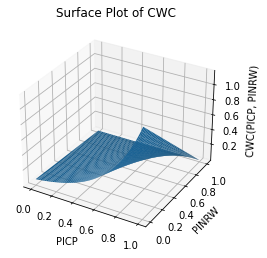

Maximum value of Z: 1.1583539630298554
Corresponding PICP and PINRW values: 0.999 0.0


In [11]:
#here we can investigate the etta and mu influence on the convolution surface shape

from mpl_toolkits.mplot3d import Axes3D

etta = 3
mu = 0.95

x = np.arange(0, 1, 0.001)
y = np.arange(0, 1, 0.001)
X, Y = np.meshgrid(x, y)
Z = (1-Y) * (np.exp(etta * (X - mu)))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel('PICP')
ax.set_ylabel('PINRW')
ax.set_zlabel('CWC(PICP, PINRW)')
ax.set_title('Surface Plot of CWC')

plt.show()

max_value = np.max(Z)
max_index = np.unravel_index(np.argmax(Z), Z.shape)
max_x = X[max_index]
max_y = Y[max_index]

print("Maximum value of Z:", max_value)
print("Corresponding PICP and PINRW values:", max_x, max_y)

In [12]:
def CWC(y_true, y_pred, etta = 3, mu = 0.95):

    return (1-PINRW(y_pred)) * (tf.exp(etta * (tf.subtract(PICP(y_true, y_pred), mu))))


In [34]:
df.tail()

<DATE>  <CLOSE>
5005 2023-03-23  2388.35
5006 2023-03-24  2391.53
5007 2023-03-27  2440.68
5008 2023-03-28  2442.19
5009 2023-03-29  2444.90

In [35]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [36]:
df[:train_size].tail()

<DATE>  <CLOSE>
4003 2019-03-11  2465.94
4004 2019-03-12  2468.25
4005 2019-03-13  2470.61
4006 2019-03-14  2457.79
4007 2019-03-15  2476.73

In [37]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))

In [38]:
X_test = test_scaled[:-1]
y_test = test_scaled[1:]

In [39]:
X_train = train_scaled[:-1]
y_train = train_scaled[1:]

In [40]:
X_train.shape

(4007, 1)

In [41]:
y_train.shape

(4007, 1)

In [42]:
X_test.shape

(1001, 1)

In [43]:
y_test.shape

(1001, 1)

Check that y is shifted 1 point ahead of X:

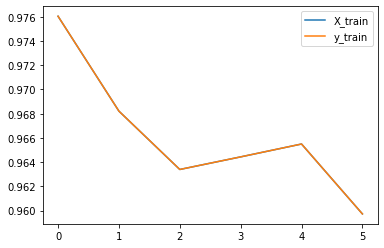

In [44]:
plt.plot(X_train[-6:], label='X_train')
plt.plot(y_train[-7:-1], label='y_train')
plt.legend()
plt.show()

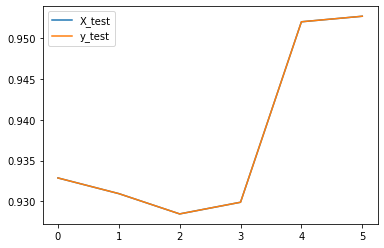

In [45]:
plt.plot(X_test[-6:], label='X_test')
plt.plot(y_test[-7:-1], label='y_test')
plt.legend()
plt.show()

In [46]:
# Define the model
model = Sequential([
    Dense(units=3),
    Dense(units=3),
    Dense(units=2)
])

# Build the model
input_shape = X_train.shape[1:]
model.build((None, *input_shape))

def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

def evaluate_nn(W, shape,X_train=X_train, Y_train=y_train):
    global model, max_value
    results = []
    for weights in W:
        model.set_weights(set_shape(weights,shape))
        predictions = model.predict(X_train)
        solution_fitness = 1-CWC(Y_train, predictions).numpy() / max_value
        results.append(solution_fitness)
    return results

In [47]:
import random


def evaluate_picp_pinrw(W, shape,X_train=X_train, Y_train=y_train):
    global model, max_value
    results = []
    i = 1
    for iteration in W:
        print("=== Iteration number ===", i)
        #if i == 358:
        #    break 
        i = i + 1
            #random_number = random.randint(0, 29)
        for weights in iteration:
            #weights = iteration[random_number]
            model.set_weights(set_shape(weights,shape))
            predictions = model.predict(X_train)
            picp = PICP(Y_train, predictions)
            pinrw = PINRW(predictions)
            results.append([picp.numpy(), pinrw.numpy()])
    return results

In [48]:
shape = get_shape(model)
x_max = 1.0 * np.ones(model.count_params())
x_min = -1.0 * x_max
bounds = (x_min, x_max)

In [49]:
model.count_params()

26

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 6         
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 2)                 8         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Generate the random initial positions
initial_positions = np.random.uniform(-0.01, 0.01, size=(30, model.count_params()))

use below block for the precomputed sub-optimal locations or don't execute it if you wish to perform a completely new search:

In [30]:
initial_positions = initial_positions + [ 1.49135765e-01, -6.01628043e-01,  6.87191798e-01,  4.00355382e-01, \
 -6.16992638e-02, -2.90330737e-02,  2.03630807e-01, -2.17484611e-04, \
  1.19836413e-01,  7.96163640e-01,  4.81197173e-01, -6.01507606e-01, \
 -7.64198904e-01, -1.12264617e-01,  4.37500645e-01,  3.39774083e-01, \
 -2.64380039e-01,  4.37342971e-01, -6.77976896e-01, -8.51519506e-01, \
  2.15491686e-02, -1.75067117e-01,  6.27608069e-01,  1.59483096e-01, \
 -1.41517380e-01,  2.39876654e-01]

In [51]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=30, dimensions=model.count_params(),
                          options=options, bounds=bounds)#, init_pos = initial_positions)

Execute if you wish to perform the new search with PSO

In [ ]:
cost, pos = optimizer.optimize(evaluate_nn, 50, X_train=X_train, Y_train=y_train,shape=shape)

2023-08-08 20:19:56,641 - pyswarms.single.global_best - INFO - Optimize for 1300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|                                       |0/1300

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:   0%|                      |1/1300, best_cost=0.844

126/126 [==============================] - 0s 726us/step


pyswarms.single.global_best:   0%|                      |2/1300, best_cost=0.844

126/126 [==============================] - 0s 641us/step


pyswarms.single.global_best:   0%|                      |3/1300, best_cost=0.844

126/126 [==============================] - 0s 638us/step


pyswarms.single.global_best:   0%|                      |4/1300, best_cost=0.797

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:   0%|                      |5/1300, best_cost=0.797

126/126 [==============================] - 0s 663us/step


pyswarms.single.global_best:   0%|                      |6/1300, best_cost=0.797

126/126 [==============================] - 0s 722us/step


pyswarms.single.global_best:   1%|                      |7/1300, best_cost=0.797

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:   1%|▏                     |8/1300, best_cost=0.797

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:   1%|▏                     |9/1300, best_cost=0.797

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:   1%|▏                    |10/1300, best_cost=0.797

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:   1%|▏                    |11/1300, best_cost=0.793

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:   1%|▏                    |12/1300, best_cost=0.793

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:   1%|▏                    |13/1300, best_cost=0.793

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:   1%|▏                    |14/1300, best_cost=0.793

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:   1%|▏                    |15/1300, best_cost=0.793

126/126 [==============================] - 0s 656us/step


pyswarms.single.global_best:   1%|▎                    |16/1300, best_cost=0.793

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:   1%|▎                    |17/1300, best_cost=0.793

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:   1%|▎                    |18/1300, best_cost=0.793

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:   1%|▎                    |19/1300, best_cost=0.792

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:   2%|▎                    |20/1300, best_cost=0.792

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:   2%|▎                    |21/1300, best_cost=0.792

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:   2%|▎                    |22/1300, best_cost=0.771

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:   2%|▎                    |23/1300, best_cost=0.771

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:   2%|▍                    |24/1300, best_cost=0.771

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:   2%|▍                    |25/1300, best_cost=0.721

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:   2%|▍                    |26/1300, best_cost=0.721

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:   2%|▍                    |27/1300, best_cost=0.721

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:   2%|▍                    |28/1300, best_cost=0.721

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:   2%|▍                    |29/1300, best_cost=0.674

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:   2%|▍                    |30/1300, best_cost=0.674

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:   2%|▌                    |31/1300, best_cost=0.674

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:   2%|▌                    |32/1300, best_cost=0.674

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:   3%|▌                    |33/1300, best_cost=0.674

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:   3%|▌                    |34/1300, best_cost=0.674

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:   3%|▌                    |35/1300, best_cost=0.674

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:   3%|▌                    |36/1300, best_cost=0.674

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:   3%|▌                    |37/1300, best_cost=0.674

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:   3%|▌                    |38/1300, best_cost=0.674

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:   3%|▋                    |39/1300, best_cost=0.674

126/126 [==============================] - 0s 550us/step


pyswarms.single.global_best:   3%|▋                    |40/1300, best_cost=0.674

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:   3%|▋                    |41/1300, best_cost=0.383

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:   3%|▋                    |42/1300, best_cost=0.383

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:   3%|▋                    |43/1300, best_cost=0.383

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:   3%|▋                    |44/1300, best_cost=0.383

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:   3%|▋                    |45/1300, best_cost=0.383

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   4%|▋                    |46/1300, best_cost=0.383

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:   4%|▊                    |47/1300, best_cost=0.383

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:   4%|▊                    |48/1300, best_cost=0.383

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   4%|▊                    |49/1300, best_cost=0.383

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:   4%|▊                    |50/1300, best_cost=0.383

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:   4%|▊                    |51/1300, best_cost=0.383

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:   4%|▊                    |52/1300, best_cost=0.383

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:   4%|▊                    |53/1300, best_cost=0.383

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:   4%|▊                    |54/1300, best_cost=0.383

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:   4%|▉                    |55/1300, best_cost=0.383

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:   4%|▉                    |56/1300, best_cost=0.383

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:   4%|▉                    |57/1300, best_cost=0.383

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:   4%|▉                    |58/1300, best_cost=0.383

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:   5%|▉                    |59/1300, best_cost=0.383

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:   5%|▉                    |60/1300, best_cost=0.383

126/126 [==============================] - 0s 552us/step


pyswarms.single.global_best:   5%|▉                    |61/1300, best_cost=0.383

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:   5%|█                    |62/1300, best_cost=0.383

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:   5%|█                    |63/1300, best_cost=0.383

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:   5%|█                    |64/1300, best_cost=0.383

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:   5%|█                    |65/1300, best_cost=0.383

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:   5%|█                    |66/1300, best_cost=0.383

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:   5%|█                    |67/1300, best_cost=0.383

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:   5%|█                    |68/1300, best_cost=0.383

126/126 [==============================] - 0s 723us/step


pyswarms.single.global_best:   5%|█                    |69/1300, best_cost=0.383

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:   5%|█▏                   |70/1300, best_cost=0.383

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:   5%|█▏                   |71/1300, best_cost=0.383

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:   6%|█▏                   |72/1300, best_cost=0.383

126/126 [==============================] - 0s 648us/step


pyswarms.single.global_best:   6%|█▏                   |73/1300, best_cost=0.383

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:   6%|█▏                   |74/1300, best_cost=0.383

126/126 [==============================] - 0s 551us/step


pyswarms.single.global_best:   6%|█▏                   |75/1300, best_cost=0.383

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:   6%|█▏                   |76/1300, best_cost=0.383

126/126 [==============================] - 0s 640us/step


pyswarms.single.global_best:   6%|█▏                   |77/1300, best_cost=0.383

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:   6%|█▎                   |78/1300, best_cost=0.383

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:   6%|█▎                   |79/1300, best_cost=0.383

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:   6%|█▎                   |80/1300, best_cost=0.383

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   6%|█▎                   |81/1300, best_cost=0.383

126/126 [==============================] - 0s 629us/step


pyswarms.single.global_best:   6%|█▎                   |82/1300, best_cost=0.383

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:   6%|█▎                   |83/1300, best_cost=0.383

126/126 [==============================] - 0s 674us/step


pyswarms.single.global_best:   6%|█▎                   |84/1300, best_cost=0.383

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:   7%|█▎                   |85/1300, best_cost=0.383

126/126 [==============================] - 0s 541us/step


pyswarms.single.global_best:   7%|█▍                   |86/1300, best_cost=0.383

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:   7%|█▍                   |87/1300, best_cost=0.383

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:   7%|█▍                   |88/1300, best_cost=0.383

126/126 [==============================] - 0s 626us/step


pyswarms.single.global_best:   7%|█▍                   |89/1300, best_cost=0.383

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:   7%|█▍                   |90/1300, best_cost=0.383

126/126 [==============================] - 0s 673us/step


pyswarms.single.global_best:   7%|█▍                   |91/1300, best_cost=0.383

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:   7%|█▍                   |92/1300, best_cost=0.383

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:   7%|█▌                   |93/1300, best_cost=0.383

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:   7%|█▌                   |94/1300, best_cost=0.383

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:   7%|█▌                   |95/1300, best_cost=0.383

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:   7%|█▌                   |96/1300, best_cost=0.383

126/126 [==============================] - 0s 683us/step


pyswarms.single.global_best:   7%|█▌                   |97/1300, best_cost=0.383

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:   8%|█▌                   |98/1300, best_cost=0.383

126/126 [==============================] - 0s 642us/step


pyswarms.single.global_best:   8%|█▌                   |99/1300, best_cost=0.383

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:   8%|█▌                  |100/1300, best_cost=0.383

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:   8%|█▌                  |101/1300, best_cost=0.383

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:   8%|█▌                  |102/1300, best_cost=0.383

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:   8%|█▌                  |103/1300, best_cost=0.383

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:   8%|█▌                  |104/1300, best_cost=0.383

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:   8%|█▌                  |105/1300, best_cost=0.383

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:   8%|█▋                  |106/1300, best_cost=0.383

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:   8%|█▋                  |107/1300, best_cost=0.383

126/126 [==============================] - 0s 682us/step


pyswarms.single.global_best:   8%|█▋                  |108/1300, best_cost=0.383

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:   8%|█▋                  |109/1300, best_cost=0.383

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:   8%|█▋                  |110/1300, best_cost=0.383

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:   9%|█▋                  |111/1300, best_cost=0.383

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:   9%|█▋                  |112/1300, best_cost=0.383

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:   9%|█▋                  |113/1300, best_cost=0.383

126/126 [==============================] - 0s 683us/step


pyswarms.single.global_best:   9%|█▊                  |114/1300, best_cost=0.383

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:   9%|█▊                  |115/1300, best_cost=0.383

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:   9%|█▊                  |116/1300, best_cost=0.383

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:   9%|█▊                  |117/1300, best_cost=0.383

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:   9%|█▊                  |118/1300, best_cost=0.383

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:   9%|█▊                  |119/1300, best_cost=0.383

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:   9%|█▊                  |120/1300, best_cost=0.383

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:   9%|█▊                  |121/1300, best_cost=0.383

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:   9%|█▉                  |122/1300, best_cost=0.383

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:   9%|█▉                  |123/1300, best_cost=0.383

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  10%|█▉                  |124/1300, best_cost=0.383

126/126 [==============================] - 0s 626us/step


pyswarms.single.global_best:  10%|█▉                  |125/1300, best_cost=0.383

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  10%|█▉                  |126/1300, best_cost=0.383

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  10%|█▉                  |127/1300, best_cost=0.383

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  10%|█▉                  |128/1300, best_cost=0.383

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  10%|█▉                  |129/1300, best_cost=0.383

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  10%|██                  |130/1300, best_cost=0.383

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  10%|██                  |131/1300, best_cost=0.383

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  10%|██                  |132/1300, best_cost=0.383

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  10%|██                  |133/1300, best_cost=0.383

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  10%|██                  |134/1300, best_cost=0.383

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  10%|██                  |135/1300, best_cost=0.383

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  10%|██                  |136/1300, best_cost=0.383

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  11%|██                  |137/1300, best_cost=0.383

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  11%|██                  |138/1300, best_cost=0.383

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  11%|██▏                 |139/1300, best_cost=0.311

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  11%|██▏                 |140/1300, best_cost=0.311

126/126 [==============================] - 0s 681us/step


pyswarms.single.global_best:  11%|██▏                 |141/1300, best_cost=0.311

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  11%|██▏                 |142/1300, best_cost=0.311

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  11%|██▏                 |143/1300, best_cost=0.311

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  11%|██▏                 |144/1300, best_cost=0.311

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  11%|██▏                 |145/1300, best_cost=0.311

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  11%|██▏                 |146/1300, best_cost=0.311

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  11%|██▎                 |147/1300, best_cost=0.311

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  11%|██▎                 |148/1300, best_cost=0.311

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  11%|██▎                 |149/1300, best_cost=0.311

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  12%|██▎                 |150/1300, best_cost=0.311

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  12%|██▎                 |151/1300, best_cost=0.273

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  12%|██▎                 |152/1300, best_cost=0.273

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  12%|██▎                 |153/1300, best_cost=0.273

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  12%|██▎                 |154/1300, best_cost=0.273

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  12%|██▍                 |155/1300, best_cost=0.273

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  12%|██▍                 |156/1300, best_cost=0.273

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  12%|██▍                 |157/1300, best_cost=0.273

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  12%|██▍                 |158/1300, best_cost=0.273

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  12%|██▍                 |159/1300, best_cost=0.273

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  12%|██▍                 |160/1300, best_cost=0.273

126/126 [==============================] - 0s 551us/step


pyswarms.single.global_best:  12%|██▍                 |161/1300, best_cost=0.273

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  12%|██▍                 |162/1300, best_cost=0.214

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  13%|██▌                 |163/1300, best_cost=0.214

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  13%|██▌                 |164/1300, best_cost=0.214

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  13%|██▌                 |165/1300, best_cost=0.214

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  13%|██▌                 |166/1300, best_cost=0.214

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  13%|██▌                 |167/1300, best_cost=0.214

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  13%|██▌                 |168/1300, best_cost=0.214

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  13%|██▌                 |169/1300, best_cost=0.214

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  13%|██▌                 |170/1300, best_cost=0.214

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  13%|██▋                 |171/1300, best_cost=0.214

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  13%|██▋                 |172/1300, best_cost=0.189

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  13%|██▋                 |173/1300, best_cost=0.189

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  13%|██▋                 |174/1300, best_cost=0.189

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  13%|██▋                 |175/1300, best_cost=0.189

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  14%|██▋                 |176/1300, best_cost=0.189

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  14%|██▋                 |177/1300, best_cost=0.189

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  14%|██▋                 |178/1300, best_cost=0.189

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  14%|██▊                 |179/1300, best_cost=0.189

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  14%|██▊                 |180/1300, best_cost=0.189

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  14%|██▊                 |181/1300, best_cost=0.189

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  14%|██▊                 |182/1300, best_cost=0.189

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  14%|██▊                 |183/1300, best_cost=0.189

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  14%|██▊                 |184/1300, best_cost=0.189

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:  14%|██▊                 |185/1300, best_cost=0.189

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  14%|██▊                 |186/1300, best_cost=0.189

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  14%|██▉                 |187/1300, best_cost=0.189

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  14%|██▉                 |188/1300, best_cost=0.189

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  15%|██▉                 |189/1300, best_cost=0.189

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  15%|██▉                 |190/1300, best_cost=0.189

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  15%|██▉                 |191/1300, best_cost=0.189

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  15%|██▉                 |192/1300, best_cost=0.189

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  15%|██▉                 |193/1300, best_cost=0.189

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  15%|██▉                 |194/1300, best_cost=0.189

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  15%|███                 |195/1300, best_cost=0.189

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  15%|███                 |196/1300, best_cost=0.189

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  15%|███                 |197/1300, best_cost=0.189

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  15%|███                 |198/1300, best_cost=0.189

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  15%|███                 |199/1300, best_cost=0.189

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  15%|███                 |200/1300, best_cost=0.189

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  15%|███                 |201/1300, best_cost=0.189

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  16%|███                 |202/1300, best_cost=0.189

126/126 [==============================] - 0s 674us/step


pyswarms.single.global_best:  16%|███                 |203/1300, best_cost=0.189

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  16%|███▏                |204/1300, best_cost=0.189

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  16%|███▏                |205/1300, best_cost=0.189

126/126 [==============================] - 0s 643us/step


pyswarms.single.global_best:  16%|███▏                |206/1300, best_cost=0.189

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  16%|███▏                |207/1300, best_cost=0.189

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  16%|███▏                |208/1300, best_cost=0.189

126/126 [==============================] - 0s 629us/step


pyswarms.single.global_best:  16%|███▏                |209/1300, best_cost=0.189

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  16%|███▏                |210/1300, best_cost=0.189

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  16%|███▏                |211/1300, best_cost=0.189

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  16%|███▎                |212/1300, best_cost=0.189

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  16%|███▎                |213/1300, best_cost=0.189

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  16%|███▎                |214/1300, best_cost=0.189

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  17%|███▎                |215/1300, best_cost=0.189

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  17%|███▎                |216/1300, best_cost=0.189

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  17%|███▎                |217/1300, best_cost=0.189

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  17%|███▎                |218/1300, best_cost=0.189

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  17%|███▎                |219/1300, best_cost=0.189

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  17%|███▍                |220/1300, best_cost=0.189

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  17%|███▍                |221/1300, best_cost=0.189

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  17%|███▍                |222/1300, best_cost=0.189

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  17%|███▍                |223/1300, best_cost=0.189

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  17%|███▍                |224/1300, best_cost=0.189

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  17%|███▍                |225/1300, best_cost=0.189

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  17%|███▍                |226/1300, best_cost=0.189

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  17%|███▍                |227/1300, best_cost=0.189

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  18%|███▌                |228/1300, best_cost=0.189

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  18%|███▌                |229/1300, best_cost=0.189

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  18%|███▌                |230/1300, best_cost=0.189

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  18%|███▌                |231/1300, best_cost=0.189

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  18%|███▌                |232/1300, best_cost=0.189

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  18%|███▌                |233/1300, best_cost=0.189

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  18%|███▌                |234/1300, best_cost=0.189

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  18%|███▌                |235/1300, best_cost=0.189

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  18%|███▋                |236/1300, best_cost=0.189

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  18%|███▋                |237/1300, best_cost=0.189

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  18%|███▋                |238/1300, best_cost=0.189

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  18%|███▋                |239/1300, best_cost=0.189

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  18%|███▋                |240/1300, best_cost=0.189

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  19%|███▋                |241/1300, best_cost=0.189

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  19%|███▋                |242/1300, best_cost=0.189

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:  19%|███▋                |243/1300, best_cost=0.189

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  19%|███▊                |244/1300, best_cost=0.189

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  19%|███▊                |245/1300, best_cost=0.189

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  19%|███▊                |246/1300, best_cost=0.189

126/126 [==============================] - 0s 646us/step


pyswarms.single.global_best:  19%|███▊                |247/1300, best_cost=0.189

126/126 [==============================] - 0s 656us/step


pyswarms.single.global_best:  19%|███▊                |248/1300, best_cost=0.189

126/126 [==============================] - 0s 752us/step


pyswarms.single.global_best:  19%|███▊                |249/1300, best_cost=0.189

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  19%|███▊                |250/1300, best_cost=0.189

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  19%|███▊                |251/1300, best_cost=0.189

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  19%|███▉                |252/1300, best_cost=0.189

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  19%|███▉                |253/1300, best_cost=0.189

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  20%|███▉                |254/1300, best_cost=0.189

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  20%|███▉                |255/1300, best_cost=0.189

126/126 [==============================] - 0s 704us/step


pyswarms.single.global_best:  20%|███▉                |256/1300, best_cost=0.189

126/126 [==============================] - 0s 684us/step


pyswarms.single.global_best:  20%|███▉                |257/1300, best_cost=0.189

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  20%|███▉                |258/1300, best_cost=0.189

126/126 [==============================] - 0s 642us/step


pyswarms.single.global_best:  20%|███▉                |259/1300, best_cost=0.189

126/126 [==============================] - 0s 671us/step


pyswarms.single.global_best:  20%|████                |260/1300, best_cost=0.189

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  20%|████                |261/1300, best_cost=0.189

126/126 [==============================] - 0s 660us/step


pyswarms.single.global_best:  20%|████                |262/1300, best_cost=0.189

126/126 [==============================] - 0s 654us/step


pyswarms.single.global_best:  20%|████                |263/1300, best_cost=0.189

126/126 [==============================] - 0s 699us/step


pyswarms.single.global_best:  20%|████                |264/1300, best_cost=0.189

126/126 [==============================] - 0s 658us/step


pyswarms.single.global_best:  20%|████                |265/1300, best_cost=0.189

126/126 [==============================] - 0s 630us/step


pyswarms.single.global_best:  20%|████                |266/1300, best_cost=0.189

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  21%|████                |267/1300, best_cost=0.189

126/126 [==============================] - 0s 851us/step


pyswarms.single.global_best:  21%|████                |268/1300, best_cost=0.189

126/126 [==============================] - 0s 661us/step


pyswarms.single.global_best:  21%|████▏               |269/1300, best_cost=0.189

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  21%|████▏               |270/1300, best_cost=0.189

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  21%|████▏               |271/1300, best_cost=0.189

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  21%|████▏               |272/1300, best_cost=0.189

126/126 [==============================] - 0s 650us/step


pyswarms.single.global_best:  21%|████▏               |273/1300, best_cost=0.189

126/126 [==============================] - 0s 652us/step


pyswarms.single.global_best:  21%|████▏               |274/1300, best_cost=0.189

126/126 [==============================] - 0s 654us/step


pyswarms.single.global_best:  21%|████▏               |275/1300, best_cost=0.189

126/126 [==============================] - 0s 645us/step


pyswarms.single.global_best:  21%|████▏               |276/1300, best_cost=0.189

126/126 [==============================] - 0s 658us/step


pyswarms.single.global_best:  21%|████▎               |277/1300, best_cost=0.189

126/126 [==============================] - 0s 667us/step


pyswarms.single.global_best:  21%|████▎               |278/1300, best_cost=0.189

126/126 [==============================] - 0s 658us/step


pyswarms.single.global_best:  21%|████▎               |279/1300, best_cost=0.189

126/126 [==============================] - 0s 774us/step


pyswarms.single.global_best:  22%|████▎               |280/1300, best_cost=0.189

126/126 [==============================] - 0s 658us/step


pyswarms.single.global_best:  22%|████▎               |281/1300, best_cost=0.189

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  22%|████▎               |282/1300, best_cost=0.189

126/126 [==============================] - 0s 712us/step


pyswarms.single.global_best:  22%|████▎               |283/1300, best_cost=0.189

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  22%|████▎               |284/1300, best_cost=0.189

126/126 [==============================] - 0s 650us/step


pyswarms.single.global_best:  22%|████▍               |285/1300, best_cost=0.189

126/126 [==============================] - 0s 640us/step


pyswarms.single.global_best:  22%|████▍               |286/1300, best_cost=0.189

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  22%|████▍               |287/1300, best_cost=0.189

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  22%|████▍               |288/1300, best_cost=0.171

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  22%|████▍               |289/1300, best_cost=0.171

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  22%|████▍               |290/1300, best_cost=0.171

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  22%|████▍               |291/1300, best_cost=0.171

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  22%|████▍               |292/1300, best_cost=0.171

126/126 [==============================] - 0s 641us/step


pyswarms.single.global_best:  23%|████▌               |293/1300, best_cost=0.171

126/126 [==============================] - 0s 648us/step


pyswarms.single.global_best:  23%|████▌               |294/1300, best_cost=0.171

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  23%|████▌               |295/1300, best_cost=0.171

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  23%|████▌               |296/1300, best_cost=0.171

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  23%|████▌               |297/1300, best_cost=0.171

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  23%|████▌               |298/1300, best_cost=0.171

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  23%|████▌               |299/1300, best_cost=0.171

126/126 [==============================] - 0s 546us/step


pyswarms.single.global_best:  23%|████▌               |300/1300, best_cost=0.171

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  23%|████▋               |301/1300, best_cost=0.171

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  23%|████▋               |302/1300, best_cost=0.171

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  23%|████▋               |303/1300, best_cost=0.171

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  23%|████▋               |304/1300, best_cost=0.171

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  23%|████▋               |305/1300, best_cost=0.171

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  24%|████▋               |306/1300, best_cost=0.171

126/126 [==============================] - 0s 644us/step


pyswarms.single.global_best:  24%|████▋               |307/1300, best_cost=0.171

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  24%|████▋               |308/1300, best_cost=0.171

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  24%|████▊               |309/1300, best_cost=0.171

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  24%|████▊               |310/1300, best_cost=0.171

126/126 [==============================] - 0s 626us/step


pyswarms.single.global_best:  24%|████▊               |311/1300, best_cost=0.171

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  24%|████▊               |312/1300, best_cost=0.171

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  24%|████▊               |313/1300, best_cost=0.171

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  24%|████▊               |314/1300, best_cost=0.171

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  24%|████▊               |315/1300, best_cost=0.171

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  24%|████▊               |316/1300, best_cost=0.171

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  24%|████▉               |317/1300, best_cost=0.171

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  24%|████▉               |318/1300, best_cost=0.171

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  25%|████▉               |319/1300, best_cost=0.171

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  25%|████▉               |320/1300, best_cost=0.171

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  25%|████▉               |321/1300, best_cost=0.171

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  25%|████▉               |322/1300, best_cost=0.171

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  25%|████▉               |323/1300, best_cost=0.171

126/126 [==============================] - 0s 671us/step


pyswarms.single.global_best:  25%|████▉               |324/1300, best_cost=0.171

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  25%|█████               |325/1300, best_cost=0.171

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  25%|█████               |326/1300, best_cost=0.171

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  25%|█████               |327/1300, best_cost=0.171

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  25%|█████               |328/1300, best_cost=0.171

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  25%|█████               |329/1300, best_cost=0.171

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  25%|█████               |330/1300, best_cost=0.171

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  25%|█████               |331/1300, best_cost=0.171

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  26%|█████               |332/1300, best_cost=0.171

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  26%|█████               |333/1300, best_cost=0.171

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:  26%|█████▏              |334/1300, best_cost=0.171

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  26%|█████▏              |335/1300, best_cost=0.171

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  26%|█████▏              |336/1300, best_cost=0.171

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  26%|█████▏              |337/1300, best_cost=0.171

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  26%|█████▏              |338/1300, best_cost=0.171

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  26%|█████▏              |339/1300, best_cost=0.171

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  26%|█████▏              |340/1300, best_cost=0.171

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  26%|█████▏              |341/1300, best_cost=0.171

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  26%|█████▎              |342/1300, best_cost=0.171

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  26%|█████▎              |343/1300, best_cost=0.171

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  26%|█████▎              |344/1300, best_cost=0.171

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  27%|█████▎              |345/1300, best_cost=0.171

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  27%|█████▎              |346/1300, best_cost=0.171

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  27%|█████▎              |347/1300, best_cost=0.171

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  27%|█████▎              |348/1300, best_cost=0.171

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  27%|█████▎              |349/1300, best_cost=0.171

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  27%|█████▍              |350/1300, best_cost=0.171

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  27%|█████▍              |351/1300, best_cost=0.171

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  27%|█████▍              |352/1300, best_cost=0.171

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  27%|█████▍              |353/1300, best_cost=0.171

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  27%|█████▍              |354/1300, best_cost=0.171

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  27%|█████▍              |355/1300, best_cost=0.171

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  27%|█████▍              |356/1300, best_cost=0.171

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  27%|█████▍              |357/1300, best_cost=0.171

126/126 [==============================] - 0s 541us/step


pyswarms.single.global_best:  28%|█████▌              |358/1300, best_cost=0.169

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  28%|█████▌              |359/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  28%|█████▌              |360/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  28%|█████▌              |361/1300, best_cost=0.169

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  28%|█████▌              |362/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  28%|█████▌              |363/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  28%|█████▌              |364/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  28%|█████▌              |365/1300, best_cost=0.169

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  28%|█████▋              |366/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  28%|█████▋              |367/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  28%|█████▋              |368/1300, best_cost=0.169

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  28%|█████▋              |369/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  28%|█████▋              |370/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  29%|█████▋              |371/1300, best_cost=0.169

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  29%|█████▋              |372/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  29%|█████▋              |373/1300, best_cost=0.169

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  29%|█████▊              |374/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  29%|█████▊              |375/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  29%|█████▊              |376/1300, best_cost=0.169

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  29%|█████▊              |377/1300, best_cost=0.169

126/126 [==============================] - 0s 844us/step


pyswarms.single.global_best:  29%|█████▊              |378/1300, best_cost=0.169

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  29%|█████▊              |379/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  29%|█████▊              |380/1300, best_cost=0.169

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  29%|█████▊              |381/1300, best_cost=0.169

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  29%|█████▉              |382/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  29%|█████▉              |383/1300, best_cost=0.169

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  30%|█████▉              |384/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  30%|█████▉              |385/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  30%|█████▉              |386/1300, best_cost=0.169

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  30%|█████▉              |387/1300, best_cost=0.169

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  30%|█████▉              |388/1300, best_cost=0.169

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  30%|█████▉              |389/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  30%|██████              |390/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  30%|██████              |391/1300, best_cost=0.169

126/126 [==============================] - 0s 536us/step


pyswarms.single.global_best:  30%|██████              |392/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  30%|██████              |393/1300, best_cost=0.169

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  30%|██████              |394/1300, best_cost=0.169

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  30%|██████              |395/1300, best_cost=0.169

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:  30%|██████              |396/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  31%|██████              |397/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  31%|██████              |398/1300, best_cost=0.169

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  31%|██████▏             |399/1300, best_cost=0.169

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  31%|██████▏             |400/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  31%|██████▏             |401/1300, best_cost=0.169

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  31%|██████▏             |402/1300, best_cost=0.169

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  31%|██████▏             |403/1300, best_cost=0.169

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  31%|██████▏             |404/1300, best_cost=0.169

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:  31%|██████▏             |405/1300, best_cost=0.169

126/126 [==============================] - 0s 542us/step


pyswarms.single.global_best:  31%|██████▏             |406/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  31%|██████▎             |407/1300, best_cost=0.169

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  31%|██████▎             |408/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  31%|██████▎             |409/1300, best_cost=0.169

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  32%|██████▎             |410/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  32%|██████▎             |411/1300, best_cost=0.169

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  32%|██████▎             |412/1300, best_cost=0.169

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  32%|██████▎             |413/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  32%|██████▎             |414/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  32%|██████▍             |415/1300, best_cost=0.169

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  32%|██████▍             |416/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  32%|██████▍             |417/1300, best_cost=0.169

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  32%|██████▍             |418/1300, best_cost=0.169

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  32%|██████▍             |419/1300, best_cost=0.169

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  32%|██████▍             |420/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  32%|██████▍             |421/1300, best_cost=0.169

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  32%|██████▍             |422/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  33%|██████▌             |423/1300, best_cost=0.169

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  33%|██████▌             |424/1300, best_cost=0.169

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  33%|██████▌             |425/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  33%|██████▌             |426/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  33%|██████▌             |427/1300, best_cost=0.169

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  33%|██████▌             |428/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  33%|██████▌             |429/1300, best_cost=0.169

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  33%|██████▌             |430/1300, best_cost=0.169

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  33%|██████▋             |431/1300, best_cost=0.169

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  33%|██████▋             |432/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  33%|██████▋             |433/1300, best_cost=0.169

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  33%|██████▋             |434/1300, best_cost=0.169

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  33%|██████▋             |435/1300, best_cost=0.169

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  34%|██████▋             |436/1300, best_cost=0.169

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  34%|██████▋             |437/1300, best_cost=0.169

126/126 [==============================] - 0s 654us/step


pyswarms.single.global_best:  34%|██████▋             |438/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  34%|██████▊             |439/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  34%|██████▊             |440/1300, best_cost=0.169

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  34%|██████▊             |441/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  34%|██████▊             |442/1300, best_cost=0.169

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  34%|██████▊             |443/1300, best_cost=0.169

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  34%|██████▊             |444/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  34%|██████▊             |445/1300, best_cost=0.169

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  34%|██████▊             |446/1300, best_cost=0.169

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  34%|██████▉             |447/1300, best_cost=0.169

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  34%|██████▉             |448/1300, best_cost=0.169

126/126 [==============================] - 0s 552us/step


pyswarms.single.global_best:  35%|██████▉             |449/1300, best_cost=0.169

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  35%|██████▉             |450/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  35%|██████▉             |451/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  35%|██████▉             |452/1300, best_cost=0.169

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  35%|██████▉             |453/1300, best_cost=0.169

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  35%|██████▉             |454/1300, best_cost=0.169

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  35%|███████             |455/1300, best_cost=0.169

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  35%|███████             |456/1300, best_cost=0.169

126/126 [==============================] - 0s 551us/step


pyswarms.single.global_best:  35%|███████             |457/1300, best_cost=0.169

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  35%|███████             |458/1300, best_cost=0.169

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:  35%|███████             |459/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  35%|███████             |460/1300, best_cost=0.169

126/126 [==============================] - 0s 540us/step


pyswarms.single.global_best:  35%|███████             |461/1300, best_cost=0.169

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  36%|███████             |462/1300, best_cost=0.169

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  36%|███████             |463/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  36%|███████▏            |464/1300, best_cost=0.169

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  36%|███████▏            |465/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  36%|███████▏            |466/1300, best_cost=0.169

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  36%|███████▏            |467/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  36%|███████▏            |468/1300, best_cost=0.169

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  36%|███████▏            |469/1300, best_cost=0.169

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  36%|███████▏            |470/1300, best_cost=0.169

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:  36%|███████▏            |471/1300, best_cost=0.169

126/126 [==============================] - 0s 634us/step


pyswarms.single.global_best:  36%|███████▎            |472/1300, best_cost=0.169

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  36%|███████▎            |473/1300, best_cost=0.169

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  36%|███████▎            |474/1300, best_cost=0.169

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  37%|███████▎            |475/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  37%|███████▎            |476/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  37%|███████▎            |477/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  37%|███████▎            |478/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  37%|███████▎            |479/1300, best_cost=0.169

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  37%|███████▍            |480/1300, best_cost=0.169

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  37%|███████▍            |481/1300, best_cost=0.169

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  37%|███████▍            |482/1300, best_cost=0.169

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  37%|███████▍            |483/1300, best_cost=0.169

126/126 [==============================] - 0s 550us/step


pyswarms.single.global_best:  37%|███████▍            |484/1300, best_cost=0.169

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  37%|███████▍            |485/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  37%|███████▍            |486/1300, best_cost=0.169

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  37%|███████▍            |487/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  38%|███████▌            |488/1300, best_cost=0.169

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  38%|███████▌            |489/1300, best_cost=0.169

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  38%|███████▌            |490/1300, best_cost=0.169

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  38%|███████▌            |491/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  38%|███████▌            |492/1300, best_cost=0.169

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  38%|███████▌            |493/1300, best_cost=0.169

126/126 [==============================] - 0s 537us/step


pyswarms.single.global_best:  38%|███████▌            |494/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  38%|███████▌            |495/1300, best_cost=0.169

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  38%|███████▋            |496/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  38%|███████▋            |497/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  38%|███████▋            |498/1300, best_cost=0.169

126/126 [==============================] - 0s 857us/step


pyswarms.single.global_best:  38%|███████▋            |499/1300, best_cost=0.169

126/126 [==============================] - 0s 675us/step


pyswarms.single.global_best:  38%|███████▋            |500/1300, best_cost=0.169

126/126 [==============================] - 0s 547us/step


pyswarms.single.global_best:  39%|███████▋            |501/1300, best_cost=0.169

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  39%|███████▋            |502/1300, best_cost=0.169

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  39%|███████▋            |503/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  39%|███████▊            |504/1300, best_cost=0.169

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  39%|███████▊            |505/1300, best_cost=0.169

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  39%|███████▊            |506/1300, best_cost=0.169

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  39%|███████▊            |507/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  39%|███████▊            |508/1300, best_cost=0.169

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  39%|███████▊            |509/1300, best_cost=0.169

126/126 [==============================] - 0s 543us/step


pyswarms.single.global_best:  39%|███████▊            |510/1300, best_cost=0.169

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  39%|███████▊            |511/1300, best_cost=0.169

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  39%|███████▉            |512/1300, best_cost=0.169

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  39%|███████▉            |513/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  40%|███████▉            |514/1300, best_cost=0.169

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  40%|███████▉            |515/1300, best_cost=0.169

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  40%|███████▉            |516/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  40%|███████▉            |517/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  40%|███████▉            |518/1300, best_cost=0.169

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  40%|███████▉            |519/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  40%|████████            |520/1300, best_cost=0.169

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  40%|████████            |521/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  40%|████████            |522/1300, best_cost=0.169

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  40%|████████            |523/1300, best_cost=0.169

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:  40%|████████            |524/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  40%|████████            |525/1300, best_cost=0.169

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  40%|████████            |526/1300, best_cost=0.169

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  41%|████████            |527/1300, best_cost=0.169

126/126 [==============================] - 0s 674us/step


pyswarms.single.global_best:  41%|████████            |528/1300, best_cost=0.169

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  41%|████████▏           |529/1300, best_cost=0.169

126/126 [==============================] - 0s 550us/step


pyswarms.single.global_best:  41%|████████▏           |530/1300, best_cost=0.169

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  41%|████████▏           |531/1300, best_cost=0.169

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  41%|████████▏           |532/1300, best_cost=0.169

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  41%|████████▏           |533/1300, best_cost=0.169

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  41%|████████▏           |534/1300, best_cost=0.169

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  41%|████████▏           |535/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  41%|████████▏           |536/1300, best_cost=0.169

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  41%|████████▎           |537/1300, best_cost=0.169

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  41%|████████▎           |538/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  41%|████████▎           |539/1300, best_cost=0.169

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  42%|████████▎           |540/1300, best_cost=0.169

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  42%|████████▎           |541/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  42%|████████▎           |542/1300, best_cost=0.169

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  42%|████████▎           |543/1300, best_cost=0.169

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  42%|████████▎           |544/1300, best_cost=0.169

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  42%|████████▍           |545/1300, best_cost=0.169

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  42%|████████▍           |546/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  42%|████████▍           |547/1300, best_cost=0.169

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  42%|████████▍           |548/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  42%|████████▍           |549/1300, best_cost=0.169

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  42%|████████▍           |550/1300, best_cost=0.169

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  42%|████████▍           |551/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  42%|████████▍           |552/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  43%|████████▌           |553/1300, best_cost=0.169

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  43%|████████▌           |554/1300, best_cost=0.169

126/126 [==============================] - 0s 648us/step


pyswarms.single.global_best:  43%|████████▌           |555/1300, best_cost=0.169

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  43%|████████▌           |556/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  43%|████████▌           |557/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  43%|████████▌           |558/1300, best_cost=0.169

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  43%|████████▌           |559/1300, best_cost=0.169

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  43%|████████▌           |560/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  43%|████████▋           |561/1300, best_cost=0.169

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  43%|████████▋           |562/1300, best_cost=0.169

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  43%|████████▋           |563/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  43%|████████▋           |564/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  43%|████████▋           |565/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  44%|████████▋           |566/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  44%|████████▋           |567/1300, best_cost=0.169

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  44%|████████▋           |568/1300, best_cost=0.169

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  44%|████████▊           |569/1300, best_cost=0.169

126/126 [==============================] - 0s 681us/step


pyswarms.single.global_best:  44%|████████▊           |570/1300, best_cost=0.169

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  44%|████████▊           |571/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  44%|████████▊           |572/1300, best_cost=0.169

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  44%|████████▊           |573/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  44%|████████▊           |574/1300, best_cost=0.169

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  44%|████████▊           |575/1300, best_cost=0.169

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  44%|████████▊           |576/1300, best_cost=0.169

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  44%|████████▉           |577/1300, best_cost=0.169

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  44%|████████▉           |578/1300, best_cost=0.169

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  45%|████████▉           |579/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  45%|████████▉           |580/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  45%|████████▉           |581/1300, best_cost=0.169

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  45%|████████▉           |582/1300, best_cost=0.169

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  45%|████████▉           |583/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  45%|████████▉           |584/1300, best_cost=0.169

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  45%|█████████           |585/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  45%|█████████           |586/1300, best_cost=0.169

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  45%|█████████           |587/1300, best_cost=0.169

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  45%|█████████           |588/1300, best_cost=0.169

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  45%|█████████           |589/1300, best_cost=0.169

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  45%|█████████           |590/1300, best_cost=0.169

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:  45%|█████████           |591/1300, best_cost=0.169

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  46%|█████████           |592/1300, best_cost=0.169

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  46%|█████████           |593/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  46%|█████████▏          |594/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  46%|█████████▏          |595/1300, best_cost=0.169

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  46%|█████████▏          |596/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  46%|█████████▏          |597/1300, best_cost=0.169

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  46%|█████████▏          |598/1300, best_cost=0.169

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  46%|█████████▏          |599/1300, best_cost=0.169

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  46%|█████████▏          |600/1300, best_cost=0.169

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  46%|█████████▏          |601/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  46%|█████████▎          |602/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  46%|█████████▎          |603/1300, best_cost=0.169

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  46%|█████████▎          |604/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  47%|█████████▎          |605/1300, best_cost=0.169

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  47%|█████████▎          |606/1300, best_cost=0.169

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  47%|█████████▎          |607/1300, best_cost=0.169

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  47%|█████████▎          |608/1300, best_cost=0.169

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  47%|█████████▎          |609/1300, best_cost=0.169

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  47%|█████████▍          |610/1300, best_cost=0.169

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:  47%|█████████▍          |611/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  47%|█████████▍          |612/1300, best_cost=0.169

126/126 [==============================] - 0s 542us/step


pyswarms.single.global_best:  47%|█████████▍          |613/1300, best_cost=0.169

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  47%|█████████▍          |614/1300, best_cost=0.169

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  47%|█████████▍          |615/1300, best_cost=0.169

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  47%|█████████▍          |616/1300, best_cost=0.169

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  47%|█████████▍          |617/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  48%|█████████▌          |618/1300, best_cost=0.169

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  48%|█████████▌          |619/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  48%|█████████▌          |620/1300, best_cost=0.169

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  48%|█████████▌          |621/1300, best_cost=0.169

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  48%|█████████▌          |622/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  48%|█████████▌          |623/1300, best_cost=0.169

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  48%|█████████▌          |624/1300, best_cost=0.169

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  48%|█████████▌          |625/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  48%|█████████▋          |626/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  48%|█████████▋          |627/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  48%|█████████▋          |628/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  48%|█████████▋          |629/1300, best_cost=0.169

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  48%|█████████▋          |630/1300, best_cost=0.169

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  49%|█████████▋          |631/1300, best_cost=0.169

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  49%|█████████▋          |632/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  49%|█████████▋          |633/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  49%|█████████▊          |634/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  49%|█████████▊          |635/1300, best_cost=0.169

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  49%|█████████▊          |636/1300, best_cost=0.169

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  49%|█████████▊          |637/1300, best_cost=0.169

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  49%|█████████▊          |638/1300, best_cost=0.169

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  49%|█████████▊          |639/1300, best_cost=0.169

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  49%|█████████▊          |640/1300, best_cost=0.169

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  49%|█████████▊          |641/1300, best_cost=0.169

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  49%|█████████▉          |642/1300, best_cost=0.169

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  49%|█████████▉          |643/1300, best_cost=0.169

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  50%|█████████▉          |644/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  50%|█████████▉          |645/1300, best_cost=0.169

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  50%|█████████▉          |646/1300, best_cost=0.169

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  50%|█████████▉          |647/1300, best_cost=0.169

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  50%|█████████▉          |648/1300, best_cost=0.169

126/126 [==============================] - 0s 536us/step


pyswarms.single.global_best:  50%|█████████▉          |649/1300, best_cost=0.169

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  50%|██████████          |650/1300, best_cost=0.169

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  50%|██████████          |651/1300, best_cost=0.169

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  50%|██████████          |652/1300, best_cost=0.169

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  50%|██████████          |653/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  50%|██████████          |654/1300, best_cost=0.169

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  50%|██████████          |655/1300, best_cost=0.169

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  50%|██████████          |656/1300, best_cost=0.169

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  51%|██████████          |657/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  51%|██████████          |658/1300, best_cost=0.169

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  51%|██████████▏         |659/1300, best_cost=0.169

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  51%|██████████▏         |660/1300, best_cost=0.169

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  51%|██████████▏         |661/1300, best_cost=0.169

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  51%|██████████▏         |662/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  51%|██████████▏         |663/1300, best_cost=0.169

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  51%|██████████▏         |664/1300, best_cost=0.169

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  51%|██████████▏         |665/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  51%|██████████▏         |666/1300, best_cost=0.169

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  51%|██████████▎         |667/1300, best_cost=0.169

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  51%|██████████▎         |668/1300, best_cost=0.169

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  51%|██████████▎         |669/1300, best_cost=0.169

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  52%|██████████▎         |670/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  52%|██████████▎         |671/1300, best_cost=0.169

126/126 [==============================] - 0s 538us/step


pyswarms.single.global_best:  52%|██████████▎         |672/1300, best_cost=0.169

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  52%|██████████▎         |673/1300, best_cost=0.169

126/126 [==============================] - 0s 640us/step


pyswarms.single.global_best:  52%|██████████▎         |674/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  52%|██████████▍         |675/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  52%|██████████▍         |676/1300, best_cost=0.169

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  52%|██████████▍         |677/1300, best_cost=0.169

126/126 [==============================] - 0s 634us/step


pyswarms.single.global_best:  52%|██████████▍         |678/1300, best_cost=0.169

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  52%|██████████▍         |679/1300, best_cost=0.169

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  52%|██████████▍         |680/1300, best_cost=0.169

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  52%|██████████▍         |681/1300, best_cost=0.169

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  52%|██████████▍         |682/1300, best_cost=0.169

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  53%|██████████▌         |683/1300, best_cost=0.169

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:  53%|██████████▌         |684/1300, best_cost=0.169

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  53%|██████████▌         |685/1300, best_cost=0.169

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  53%|██████████▌         |686/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  53%|██████████▌         |687/1300, best_cost=0.169

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  53%|██████████▌         |688/1300, best_cost=0.169

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  53%|██████████▌         |689/1300, best_cost=0.169

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  53%|██████████▌         |690/1300, best_cost=0.169

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  53%|██████████▋         |691/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  53%|██████████▋         |692/1300, best_cost=0.169

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  53%|██████████▋         |693/1300, best_cost=0.169

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  53%|██████████▋         |694/1300, best_cost=0.169

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:  53%|██████████▋         |695/1300, best_cost=0.169

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  54%|██████████▋         |696/1300, best_cost=0.169

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  54%|██████████▋         |697/1300, best_cost=0.169

126/126 [==============================] - 0s 541us/step


pyswarms.single.global_best:  54%|██████████▋         |698/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  54%|██████████▊         |699/1300, best_cost=0.169

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  54%|██████████▊         |700/1300, best_cost=0.169

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  54%|██████████▊         |701/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  54%|██████████▊         |702/1300, best_cost=0.169

126/126 [==============================] - 0s 553us/step


pyswarms.single.global_best:  54%|██████████▊         |703/1300, best_cost=0.169

126/126 [==============================] - 0s 554us/step


pyswarms.single.global_best:  54%|██████████▊         |704/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  54%|██████████▊         |705/1300, best_cost=0.169

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  54%|██████████▊         |706/1300, best_cost=0.169

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  54%|██████████▉         |707/1300, best_cost=0.169

126/126 [==============================] - 0s 629us/step


pyswarms.single.global_best:  54%|██████████▉         |708/1300, best_cost=0.169

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  55%|██████████▉         |709/1300, best_cost=0.169

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  55%|██████████▉         |710/1300, best_cost=0.169

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  55%|██████████▉         |711/1300, best_cost=0.169

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  55%|██████████▉         |712/1300, best_cost=0.169

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  55%|██████████▉         |713/1300, best_cost=0.169

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  55%|██████████▉         |714/1300, best_cost=0.169

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  55%|███████████         |715/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  55%|███████████         |716/1300, best_cost=0.169

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  55%|███████████         |717/1300, best_cost=0.169

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  55%|███████████         |718/1300, best_cost=0.169

126/126 [==============================] - 0s 554us/step


pyswarms.single.global_best:  55%|███████████         |719/1300, best_cost=0.169

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  55%|███████████         |720/1300, best_cost=0.169

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  55%|███████████         |721/1300, best_cost=0.169

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  56%|███████████         |722/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  56%|███████████         |723/1300, best_cost=0.169

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  56%|███████████▏        |724/1300, best_cost=0.169

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  56%|███████████▏        |725/1300, best_cost=0.169

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  56%|███████████▏        |726/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  56%|███████████▏        |727/1300, best_cost=0.169

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  56%|███████████▏        |728/1300, best_cost=0.169

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  56%|███████████▏        |729/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  56%|███████████▏        |730/1300, best_cost=0.169

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  56%|███████████▏        |731/1300, best_cost=0.169

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  56%|███████████▎        |732/1300, best_cost=0.169

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  56%|███████████▎        |733/1300, best_cost=0.169

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  56%|███████████▎        |734/1300, best_cost=0.169

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  57%|███████████▎        |735/1300, best_cost=0.169

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  57%|███████████▎        |736/1300, best_cost=0.169

126/126 [==============================] - 0s 542us/step


pyswarms.single.global_best:  57%|███████████▎        |737/1300, best_cost=0.169

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  57%|███████████▎        |738/1300, best_cost=0.169

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  57%|███████████▎        |739/1300, best_cost=0.169

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  57%|███████████▍        |740/1300, best_cost=0.169

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  57%|███████████▍        |741/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  57%|███████████▍        |742/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  57%|███████████▍        |743/1300, best_cost=0.169

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  57%|███████████▍        |744/1300, best_cost=0.169

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  57%|███████████▍        |745/1300, best_cost=0.169

126/126 [==============================] - 0s 635us/step


pyswarms.single.global_best:  57%|███████████▍        |746/1300, best_cost=0.169

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  57%|███████████▍        |747/1300, best_cost=0.169

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  58%|███████████▌        |748/1300, best_cost=0.169

126/126 [==============================] - 0s 546us/step


pyswarms.single.global_best:  58%|███████████▌        |749/1300, best_cost=0.169

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  58%|███████████▌        |750/1300, best_cost=0.169

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  58%|███████████▌        |751/1300, best_cost=0.169

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  58%|███████████▌        |752/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  58%|███████████▌        |753/1300, best_cost=0.169

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  58%|███████████▌        |754/1300, best_cost=0.169

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  58%|███████████▌        |755/1300, best_cost=0.169

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  58%|███████████▋        |756/1300, best_cost=0.169

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  58%|███████████▋        |757/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  58%|███████████▋        |758/1300, best_cost=0.169

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  58%|███████████▋        |759/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  58%|███████████▋        |760/1300, best_cost=0.169

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  59%|███████████▋        |761/1300, best_cost=0.169

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  59%|███████████▋        |762/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  59%|███████████▋        |763/1300, best_cost=0.169

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  59%|███████████▊        |764/1300, best_cost=0.169

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  59%|███████████▊        |765/1300, best_cost=0.169

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  59%|███████████▊        |766/1300, best_cost=0.169

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  59%|███████████▊        |767/1300, best_cost=0.169

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  59%|███████████▊        |768/1300, best_cost=0.169

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  59%|███████████▊        |769/1300, best_cost=0.169

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  59%|███████████▊        |770/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  59%|███████████▊        |771/1300, best_cost=0.169

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  59%|███████████▉        |772/1300, best_cost=0.169

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  59%|███████████▉        |773/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  60%|███████████▉        |774/1300, best_cost=0.169

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  60%|███████████▉        |775/1300, best_cost=0.169

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  60%|███████████▉        |776/1300, best_cost=0.169

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  60%|███████████▉        |777/1300, best_cost=0.169

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  60%|███████████▉        |778/1300, best_cost=0.169

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  60%|███████████▉        |779/1300, best_cost=0.169

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  60%|████████████        |780/1300, best_cost=0.169

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  60%|████████████        |781/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  60%|████████████        |782/1300, best_cost=0.169

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  60%|████████████        |783/1300, best_cost=0.169

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  60%|████████████        |784/1300, best_cost=0.169

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  60%|████████████        |785/1300, best_cost=0.169

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  60%|████████████        |786/1300, best_cost=0.169

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  61%|████████████        |787/1300, best_cost=0.169

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  61%|████████████        |788/1300, best_cost=0.169

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  61%|████████████▏       |789/1300, best_cost=0.169

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  61%|████████████▏       |790/1300, best_cost=0.169

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  61%|████████████▏       |791/1300, best_cost=0.169

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  61%|████████████▏       |792/1300, best_cost=0.169

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  61%|████████████▏       |793/1300, best_cost=0.169

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  61%|████████████▏       |794/1300, best_cost=0.169

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  61%|████████████▏       |795/1300, best_cost=0.169

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  61%|████████████▏       |796/1300, best_cost=0.169

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  61%|████████████▎       |797/1300, best_cost=0.169

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  61%|████████████▎       |798/1300, best_cost=0.169

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  61%|████████████▎       |799/1300, best_cost=0.165

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  62%|████████████▎       |800/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  62%|████████████▎       |801/1300, best_cost=0.165

126/126 [==============================] - 0s 554us/step


pyswarms.single.global_best:  62%|████████████▎       |802/1300, best_cost=0.165

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  62%|████████████▎       |803/1300, best_cost=0.165

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  62%|████████████▎       |804/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  62%|████████████▍       |805/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  62%|████████████▍       |806/1300, best_cost=0.165

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  62%|████████████▍       |807/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  62%|████████████▍       |808/1300, best_cost=0.165

126/126 [==============================] - 0s 641us/step


pyswarms.single.global_best:  62%|████████████▍       |809/1300, best_cost=0.165

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  62%|████████████▍       |810/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  62%|████████████▍       |811/1300, best_cost=0.165

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  62%|████████████▍       |812/1300, best_cost=0.165

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  63%|████████████▌       |813/1300, best_cost=0.165

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  63%|████████████▌       |814/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  63%|████████████▌       |815/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  63%|████████████▌       |816/1300, best_cost=0.165

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  63%|████████████▌       |817/1300, best_cost=0.165

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  63%|████████████▌       |818/1300, best_cost=0.165

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  63%|████████████▌       |819/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  63%|████████████▌       |820/1300, best_cost=0.165

126/126 [==============================] - 0s 554us/step


pyswarms.single.global_best:  63%|████████████▋       |821/1300, best_cost=0.165

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  63%|████████████▋       |822/1300, best_cost=0.165

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  63%|████████████▋       |823/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  63%|████████████▋       |824/1300, best_cost=0.165

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  63%|████████████▋       |825/1300, best_cost=0.165

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  64%|████████████▋       |826/1300, best_cost=0.165

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  64%|████████████▋       |827/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  64%|████████████▋       |828/1300, best_cost=0.165

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  64%|████████████▊       |829/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  64%|████████████▊       |830/1300, best_cost=0.165

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  64%|████████████▊       |831/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  64%|████████████▊       |832/1300, best_cost=0.165

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  64%|████████████▊       |833/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  64%|████████████▊       |834/1300, best_cost=0.165

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  64%|████████████▊       |835/1300, best_cost=0.165

126/126 [==============================] - 0s 551us/step


pyswarms.single.global_best:  64%|████████████▊       |836/1300, best_cost=0.165

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  64%|████████████▉       |837/1300, best_cost=0.165

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  64%|████████████▉       |838/1300, best_cost=0.165

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  65%|████████████▉       |839/1300, best_cost=0.165

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  65%|████████████▉       |840/1300, best_cost=0.165

126/126 [==============================] - 0s 626us/step


pyswarms.single.global_best:  65%|████████████▉       |841/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  65%|████████████▉       |842/1300, best_cost=0.165

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  65%|████████████▉       |843/1300, best_cost=0.165

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  65%|████████████▉       |844/1300, best_cost=0.165

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  65%|█████████████       |845/1300, best_cost=0.165

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  65%|█████████████       |846/1300, best_cost=0.165

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  65%|█████████████       |847/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  65%|█████████████       |848/1300, best_cost=0.165

126/126 [==============================] - 0s 624us/step


pyswarms.single.global_best:  65%|█████████████       |849/1300, best_cost=0.165

126/126 [==============================] - 0s 535us/step


pyswarms.single.global_best:  65%|█████████████       |850/1300, best_cost=0.165

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  65%|█████████████       |851/1300, best_cost=0.165

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  66%|█████████████       |852/1300, best_cost=0.165

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  66%|█████████████       |853/1300, best_cost=0.165

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  66%|█████████████▏      |854/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  66%|█████████████▏      |855/1300, best_cost=0.165

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  66%|█████████████▏      |856/1300, best_cost=0.165

126/126 [==============================] - 0s 543us/step


pyswarms.single.global_best:  66%|█████████████▏      |857/1300, best_cost=0.165

126/126 [==============================] - 0s 550us/step


pyswarms.single.global_best:  66%|█████████████▏      |858/1300, best_cost=0.165

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  66%|█████████████▏      |859/1300, best_cost=0.165

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  66%|█████████████▏      |860/1300, best_cost=0.165

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  66%|█████████████▏      |861/1300, best_cost=0.165

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  66%|█████████████▎      |862/1300, best_cost=0.165

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  66%|█████████████▎      |863/1300, best_cost=0.165

126/126 [==============================] - 0s 554us/step


pyswarms.single.global_best:  66%|█████████████▎      |864/1300, best_cost=0.165

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  67%|█████████████▎      |865/1300, best_cost=0.165

126/126 [==============================] - 0s 571us/step


pyswarms.single.global_best:  67%|█████████████▎      |866/1300, best_cost=0.165

126/126 [==============================] - 0s 626us/step


pyswarms.single.global_best:  67%|█████████████▎      |867/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  67%|█████████████▎      |868/1300, best_cost=0.165

126/126 [==============================] - 0s 546us/step


pyswarms.single.global_best:  67%|█████████████▎      |869/1300, best_cost=0.165

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  67%|█████████████▍      |870/1300, best_cost=0.165

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  67%|█████████████▍      |871/1300, best_cost=0.165

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  67%|█████████████▍      |872/1300, best_cost=0.165

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  67%|█████████████▍      |873/1300, best_cost=0.165

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  67%|█████████████▍      |874/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  67%|█████████████▍      |875/1300, best_cost=0.165

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  67%|█████████████▍      |876/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  67%|█████████████▍      |877/1300, best_cost=0.165

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  68%|█████████████▌      |878/1300, best_cost=0.165

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  68%|█████████████▌      |879/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  68%|█████████████▌      |880/1300, best_cost=0.165

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  68%|█████████████▌      |881/1300, best_cost=0.165

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  68%|█████████████▌      |882/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  68%|█████████████▌      |883/1300, best_cost=0.165

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  68%|█████████████▌      |884/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  68%|█████████████▌      |885/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  68%|█████████████▋      |886/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  68%|█████████████▋      |887/1300, best_cost=0.165

126/126 [==============================] - 0s 535us/step


pyswarms.single.global_best:  68%|█████████████▋      |888/1300, best_cost=0.165

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  68%|█████████████▋      |889/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  68%|█████████████▋      |890/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  69%|█████████████▋      |891/1300, best_cost=0.165

126/126 [==============================] - 0s 666us/step


pyswarms.single.global_best:  69%|█████████████▋      |892/1300, best_cost=0.165

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  69%|█████████████▋      |893/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  69%|█████████████▊      |894/1300, best_cost=0.165

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  69%|█████████████▊      |895/1300, best_cost=0.165

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  69%|█████████████▊      |896/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  69%|█████████████▊      |897/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  69%|█████████████▊      |898/1300, best_cost=0.165

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  69%|█████████████▊      |899/1300, best_cost=0.165

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  69%|█████████████▊      |900/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  69%|█████████████▊      |901/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  69%|█████████████▉      |902/1300, best_cost=0.165

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  69%|█████████████▉      |903/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  70%|█████████████▉      |904/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  70%|█████████████▉      |905/1300, best_cost=0.165

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:  70%|█████████████▉      |906/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  70%|█████████████▉      |907/1300, best_cost=0.165

126/126 [==============================] - 0s 670us/step


pyswarms.single.global_best:  70%|█████████████▉      |908/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  70%|█████████████▉      |909/1300, best_cost=0.165

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  70%|██████████████      |910/1300, best_cost=0.165

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  70%|██████████████      |911/1300, best_cost=0.165

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  70%|██████████████      |912/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  70%|██████████████      |913/1300, best_cost=0.165

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  70%|██████████████      |914/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  70%|██████████████      |915/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  70%|██████████████      |916/1300, best_cost=0.165

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  71%|██████████████      |917/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  71%|██████████████      |918/1300, best_cost=0.165

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  71%|██████████████▏     |919/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  71%|██████████████▏     |920/1300, best_cost=0.165

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  71%|██████████████▏     |921/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  71%|██████████████▏     |922/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  71%|██████████████▏     |923/1300, best_cost=0.165

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  71%|██████████████▏     |924/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  71%|██████████████▏     |925/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  71%|██████████████▏     |926/1300, best_cost=0.165

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  71%|██████████████▎     |927/1300, best_cost=0.165

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  71%|██████████████▎     |928/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  71%|██████████████▎     |929/1300, best_cost=0.165

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  72%|██████████████▎     |930/1300, best_cost=0.165

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  72%|██████████████▎     |931/1300, best_cost=0.165

126/126 [==============================] - 0s 554us/step


pyswarms.single.global_best:  72%|██████████████▎     |932/1300, best_cost=0.165

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  72%|██████████████▎     |933/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  72%|██████████████▎     |934/1300, best_cost=0.165

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  72%|██████████████▍     |935/1300, best_cost=0.165

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  72%|██████████████▍     |936/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  72%|██████████████▍     |937/1300, best_cost=0.165

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  72%|██████████████▍     |938/1300, best_cost=0.165

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  72%|██████████████▍     |939/1300, best_cost=0.165

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  72%|██████████████▍     |940/1300, best_cost=0.165

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  72%|██████████████▍     |941/1300, best_cost=0.165

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  72%|██████████████▍     |942/1300, best_cost=0.165

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  73%|██████████████▌     |943/1300, best_cost=0.165

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  73%|██████████████▌     |944/1300, best_cost=0.165

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  73%|██████████████▌     |945/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  73%|██████████████▌     |946/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  73%|██████████████▌     |947/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  73%|██████████████▌     |948/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  73%|██████████████▌     |949/1300, best_cost=0.165

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  73%|██████████████▌     |950/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  73%|██████████████▋     |951/1300, best_cost=0.165

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  73%|██████████████▋     |952/1300, best_cost=0.165

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  73%|██████████████▋     |953/1300, best_cost=0.165

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  73%|██████████████▋     |954/1300, best_cost=0.165

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  73%|██████████████▋     |955/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  74%|██████████████▋     |956/1300, best_cost=0.165

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  74%|██████████████▋     |957/1300, best_cost=0.165

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  74%|██████████████▋     |958/1300, best_cost=0.165

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  74%|██████████████▊     |959/1300, best_cost=0.165

126/126 [==============================] - 0s 658us/step


pyswarms.single.global_best:  74%|██████████████▊     |960/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  74%|██████████████▊     |961/1300, best_cost=0.165

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  74%|██████████████▊     |962/1300, best_cost=0.165

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  74%|██████████████▊     |963/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  74%|██████████████▊     |964/1300, best_cost=0.165

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  74%|██████████████▊     |965/1300, best_cost=0.165

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  74%|██████████████▊     |966/1300, best_cost=0.165

126/126 [==============================] - 0s 532us/step


pyswarms.single.global_best:  74%|██████████████▉     |967/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  74%|██████████████▉     |968/1300, best_cost=0.165

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  75%|██████████████▉     |969/1300, best_cost=0.165

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  75%|██████████████▉     |970/1300, best_cost=0.165

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  75%|██████████████▉     |971/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  75%|██████████████▉     |972/1300, best_cost=0.165

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  75%|██████████████▉     |973/1300, best_cost=0.165

126/126 [==============================] - 0s 626us/step


pyswarms.single.global_best:  75%|██████████████▉     |974/1300, best_cost=0.165

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  75%|███████████████     |975/1300, best_cost=0.165

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  75%|███████████████     |976/1300, best_cost=0.165

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  75%|███████████████     |977/1300, best_cost=0.165

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  75%|███████████████     |978/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  75%|███████████████     |979/1300, best_cost=0.165

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  75%|███████████████     |980/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  75%|███████████████     |981/1300, best_cost=0.165

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  76%|███████████████     |982/1300, best_cost=0.165

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  76%|███████████████     |983/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  76%|███████████████▏    |984/1300, best_cost=0.165

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  76%|███████████████▏    |985/1300, best_cost=0.165

126/126 [==============================] - 0s 645us/step


pyswarms.single.global_best:  76%|███████████████▏    |986/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  76%|███████████████▏    |987/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  76%|███████████████▏    |988/1300, best_cost=0.165

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  76%|███████████████▏    |989/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  76%|███████████████▏    |990/1300, best_cost=0.165

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  76%|███████████████▏    |991/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  76%|███████████████▎    |992/1300, best_cost=0.165

126/126 [==============================] - 0s 539us/step


pyswarms.single.global_best:  76%|███████████████▎    |993/1300, best_cost=0.165

126/126 [==============================] - 0s 612us/step


pyswarms.single.global_best:  76%|███████████████▎    |994/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  77%|███████████████▎    |995/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  77%|███████████████▎    |996/1300, best_cost=0.165

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  77%|███████████████▎    |997/1300, best_cost=0.165

126/126 [==============================] - 0s 604us/step


pyswarms.single.global_best:  77%|███████████████▎    |998/1300, best_cost=0.165

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  77%|███████████████▎    |999/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  77%|██████████████▌    |1000/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  77%|██████████████▋    |1001/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  77%|██████████████▋    |1002/1300, best_cost=0.165

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  77%|██████████████▋    |1003/1300, best_cost=0.165

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  77%|██████████████▋    |1004/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  77%|██████████████▋    |1005/1300, best_cost=0.165

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  77%|██████████████▋    |1006/1300, best_cost=0.165

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  77%|██████████████▋    |1007/1300, best_cost=0.165

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  78%|██████████████▋    |1008/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  78%|██████████████▋    |1009/1300, best_cost=0.165

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  78%|██████████████▊    |1010/1300, best_cost=0.165

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  78%|██████████████▊    |1011/1300, best_cost=0.165

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  78%|██████████████▊    |1012/1300, best_cost=0.165

126/126 [==============================] - 0s 549us/step


pyswarms.single.global_best:  78%|██████████████▊    |1013/1300, best_cost=0.165

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  78%|██████████████▊    |1014/1300, best_cost=0.165

126/126 [==============================] - 0s 541us/step


pyswarms.single.global_best:  78%|██████████████▊    |1015/1300, best_cost=0.165

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  78%|██████████████▊    |1016/1300, best_cost=0.165

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  78%|██████████████▊    |1017/1300, best_cost=0.165

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  78%|██████████████▉    |1018/1300, best_cost=0.165

126/126 [==============================] - 0s 614us/step


pyswarms.single.global_best:  78%|██████████████▉    |1019/1300, best_cost=0.165

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  78%|██████████████▉    |1020/1300, best_cost=0.165

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  79%|██████████████▉    |1021/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  79%|██████████████▉    |1022/1300, best_cost=0.165

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  79%|██████████████▉    |1023/1300, best_cost=0.165

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  79%|██████████████▉    |1024/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  79%|██████████████▉    |1025/1300, best_cost=0.165

126/126 [==============================] - 0s 606us/step


pyswarms.single.global_best:  79%|██████████████▉    |1026/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  79%|███████████████    |1027/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  79%|███████████████    |1028/1300, best_cost=0.165

126/126 [==============================] - 0s 565us/step


pyswarms.single.global_best:  79%|███████████████    |1029/1300, best_cost=0.165

126/126 [==============================] - 0s 556us/step


pyswarms.single.global_best:  79%|███████████████    |1030/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  79%|███████████████    |1031/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  79%|███████████████    |1032/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  79%|███████████████    |1033/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  80%|███████████████    |1034/1300, best_cost=0.165

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  80%|███████████████▏   |1035/1300, best_cost=0.165

126/126 [==============================] - 0s 567us/step


pyswarms.single.global_best:  80%|███████████████▏   |1036/1300, best_cost=0.165

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  80%|███████████████▏   |1037/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  80%|███████████████▏   |1038/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  80%|███████████████▏   |1039/1300, best_cost=0.165

126/126 [==============================] - 0s 919us/step


pyswarms.single.global_best:  80%|███████████████▏   |1040/1300, best_cost=0.165

126/126 [==============================] - 0s 667us/step


pyswarms.single.global_best:  80%|███████████████▏   |1041/1300, best_cost=0.165

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  80%|███████████████▏   |1042/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  80%|███████████████▏   |1043/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  80%|███████████████▎   |1044/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  80%|███████████████▎   |1045/1300, best_cost=0.165

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  80%|███████████████▎   |1046/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  81%|███████████████▎   |1047/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  81%|███████████████▎   |1048/1300, best_cost=0.165

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  81%|███████████████▎   |1049/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  81%|███████████████▎   |1050/1300, best_cost=0.165

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  81%|███████████████▎   |1051/1300, best_cost=0.165

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  81%|███████████████▍   |1052/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  81%|███████████████▍   |1053/1300, best_cost=0.165

126/126 [==============================] - 0s 544us/step


pyswarms.single.global_best:  81%|███████████████▍   |1054/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  81%|███████████████▍   |1055/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  81%|███████████████▍   |1056/1300, best_cost=0.165

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  81%|███████████████▍   |1057/1300, best_cost=0.165

126/126 [==============================] - 0s 621us/step


pyswarms.single.global_best:  81%|███████████████▍   |1058/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  81%|███████████████▍   |1059/1300, best_cost=0.165

126/126 [==============================] - 0s 648us/step


pyswarms.single.global_best:  82%|███████████████▍   |1060/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  82%|███████████████▌   |1061/1300, best_cost=0.165

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  82%|███████████████▌   |1062/1300, best_cost=0.165

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  82%|███████████████▌   |1063/1300, best_cost=0.165

126/126 [==============================] - 0s 649us/step


pyswarms.single.global_best:  82%|███████████████▌   |1064/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  82%|███████████████▌   |1065/1300, best_cost=0.165

126/126 [==============================] - 0s 636us/step


pyswarms.single.global_best:  82%|███████████████▌   |1066/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  82%|███████████████▌   |1067/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  82%|███████████████▌   |1068/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  82%|███████████████▌   |1069/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  82%|███████████████▋   |1070/1300, best_cost=0.165

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  82%|███████████████▋   |1071/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  82%|███████████████▋   |1072/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  83%|███████████████▋   |1073/1300, best_cost=0.165

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  83%|███████████████▋   |1074/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  83%|███████████████▋   |1075/1300, best_cost=0.165

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  83%|███████████████▋   |1076/1300, best_cost=0.165

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  83%|███████████████▋   |1077/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  83%|███████████████▊   |1078/1300, best_cost=0.165

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  83%|███████████████▊   |1079/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  83%|███████████████▊   |1080/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  83%|███████████████▊   |1081/1300, best_cost=0.165

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  83%|███████████████▊   |1082/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  83%|███████████████▊   |1083/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  83%|███████████████▊   |1084/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  83%|███████████████▊   |1085/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  84%|███████████████▊   |1086/1300, best_cost=0.165

126/126 [==============================] - 0s 640us/step


pyswarms.single.global_best:  84%|███████████████▉   |1087/1300, best_cost=0.165

126/126 [==============================] - 0s 552us/step


pyswarms.single.global_best:  84%|███████████████▉   |1088/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  84%|███████████████▉   |1089/1300, best_cost=0.165

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  84%|███████████████▉   |1090/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  84%|███████████████▉   |1091/1300, best_cost=0.165

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  84%|███████████████▉   |1092/1300, best_cost=0.165

126/126 [==============================] - 0s 555us/step


pyswarms.single.global_best:  84%|███████████████▉   |1093/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  84%|███████████████▉   |1094/1300, best_cost=0.165

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  84%|████████████████   |1095/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  84%|████████████████   |1096/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  84%|████████████████   |1097/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  84%|████████████████   |1098/1300, best_cost=0.165

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  85%|████████████████   |1099/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  85%|████████████████   |1100/1300, best_cost=0.165

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  85%|████████████████   |1101/1300, best_cost=0.165

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  85%|████████████████   |1102/1300, best_cost=0.165

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  85%|████████████████   |1103/1300, best_cost=0.165

126/126 [==============================] - 0s 675us/step


pyswarms.single.global_best:  85%|████████████████▏  |1104/1300, best_cost=0.165

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  85%|████████████████▏  |1105/1300, best_cost=0.165

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  85%|████████████████▏  |1106/1300, best_cost=0.165

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  85%|████████████████▏  |1107/1300, best_cost=0.165

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  85%|████████████████▏  |1108/1300, best_cost=0.165

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  85%|████████████████▏  |1109/1300, best_cost=0.165

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  85%|████████████████▏  |1110/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  85%|████████████████▏  |1111/1300, best_cost=0.165

126/126 [==============================] - 0s 588us/step


pyswarms.single.global_best:  86%|████████████████▎  |1112/1300, best_cost=0.165

126/126 [==============================] - 0s 627us/step


pyswarms.single.global_best:  86%|████████████████▎  |1113/1300, best_cost=0.165

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  86%|████████████████▎  |1114/1300, best_cost=0.165

126/126 [==============================] - 0s 620us/step


pyswarms.single.global_best:  86%|████████████████▎  |1115/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  86%|████████████████▎  |1116/1300, best_cost=0.165

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  86%|████████████████▎  |1117/1300, best_cost=0.165

126/126 [==============================] - 0s 551us/step


pyswarms.single.global_best:  86%|████████████████▎  |1118/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  86%|████████████████▎  |1119/1300, best_cost=0.165

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  86%|████████████████▎  |1120/1300, best_cost=0.165

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  86%|████████████████▍  |1121/1300, best_cost=0.165

126/126 [==============================] - 0s 617us/step


pyswarms.single.global_best:  86%|████████████████▍  |1122/1300, best_cost=0.165

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  86%|████████████████▍  |1123/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  86%|████████████████▍  |1124/1300, best_cost=0.165

126/126 [==============================] - 0s 616us/step


pyswarms.single.global_best:  87%|████████████████▍  |1125/1300, best_cost=0.165

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  87%|████████████████▍  |1126/1300, best_cost=0.165

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  87%|████████████████▍  |1127/1300, best_cost=0.165

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  87%|████████████████▍  |1128/1300, best_cost=0.165

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  87%|████████████████▌  |1129/1300, best_cost=0.165

126/126 [==============================] - 0s 602us/step


pyswarms.single.global_best:  87%|████████████████▌  |1130/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  87%|████████████████▌  |1131/1300, best_cost=0.165

126/126 [==============================] - 0s 682us/step


pyswarms.single.global_best:  87%|████████████████▌  |1132/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  87%|████████████████▌  |1133/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  87%|████████████████▌  |1134/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  87%|████████████████▌  |1135/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  87%|████████████████▌  |1136/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  87%|████████████████▌  |1137/1300, best_cost=0.165

126/126 [==============================] - 0s 557us/step


pyswarms.single.global_best:  88%|████████████████▋  |1138/1300, best_cost=0.165

126/126 [==============================] - 0s 615us/step


pyswarms.single.global_best:  88%|████████████████▋  |1139/1300, best_cost=0.165

126/126 [==============================] - 0s 651us/step


pyswarms.single.global_best:  88%|████████████████▋  |1140/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  88%|████████████████▋  |1141/1300, best_cost=0.165

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  88%|████████████████▋  |1142/1300, best_cost=0.165

126/126 [==============================] - 0s 550us/step


pyswarms.single.global_best:  88%|████████████████▋  |1143/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  88%|████████████████▋  |1144/1300, best_cost=0.165

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  88%|████████████████▋  |1145/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  88%|████████████████▋  |1146/1300, best_cost=0.165

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  88%|████████████████▊  |1147/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  88%|████████████████▊  |1148/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  88%|████████████████▊  |1149/1300, best_cost=0.165

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  88%|████████████████▊  |1150/1300, best_cost=0.165

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  89%|████████████████▊  |1151/1300, best_cost=0.165

126/126 [==============================] - 0s 628us/step


pyswarms.single.global_best:  89%|████████████████▊  |1152/1300, best_cost=0.165

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  89%|████████████████▊  |1153/1300, best_cost=0.165

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  89%|████████████████▊  |1154/1300, best_cost=0.165

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  89%|████████████████▉  |1155/1300, best_cost=0.165

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  89%|████████████████▉  |1156/1300, best_cost=0.165

126/126 [==============================] - 0s 572us/step


pyswarms.single.global_best:  89%|████████████████▉  |1157/1300, best_cost=0.165

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  89%|████████████████▉  |1158/1300, best_cost=0.165

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  89%|████████████████▉  |1159/1300, best_cost=0.165

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  89%|████████████████▉  |1160/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  89%|████████████████▉  |1161/1300, best_cost=0.165

126/126 [==============================] - 0s 657us/step


pyswarms.single.global_best:  89%|████████████████▉  |1162/1300, best_cost=0.165

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  89%|████████████████▉  |1163/1300, best_cost=0.165

126/126 [==============================] - 0s 547us/step


pyswarms.single.global_best:  90%|█████████████████  |1164/1300, best_cost=0.165

126/126 [==============================] - 0s 637us/step


pyswarms.single.global_best:  90%|█████████████████  |1165/1300, best_cost=0.165

126/126 [==============================] - 0s 633us/step


pyswarms.single.global_best:  90%|█████████████████  |1166/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  90%|█████████████████  |1167/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  90%|█████████████████  |1168/1300, best_cost=0.165

126/126 [==============================] - 0s 649us/step


pyswarms.single.global_best:  90%|█████████████████  |1169/1300, best_cost=0.165

126/126 [==============================] - 0s 561us/step


pyswarms.single.global_best:  90%|█████████████████  |1170/1300, best_cost=0.165

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  90%|█████████████████  |1171/1300, best_cost=0.165

126/126 [==============================] - 0s 645us/step


pyswarms.single.global_best:  90%|█████████████████▏ |1172/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  90%|█████████████████▏ |1173/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  90%|█████████████████▏ |1174/1300, best_cost=0.165

126/126 [==============================] - 0s 608us/step


pyswarms.single.global_best:  90%|█████████████████▏ |1175/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  90%|█████████████████▏ |1176/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  91%|█████████████████▏ |1177/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  91%|█████████████████▏ |1178/1300, best_cost=0.165

126/126 [==============================] - 0s 563us/step


pyswarms.single.global_best:  91%|█████████████████▏ |1179/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  91%|█████████████████▏ |1180/1300, best_cost=0.165

126/126 [==============================] - 0s 655us/step


pyswarms.single.global_best:  91%|█████████████████▎ |1181/1300, best_cost=0.165

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  91%|█████████████████▎ |1182/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  91%|█████████████████▎ |1183/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  91%|█████████████████▎ |1184/1300, best_cost=0.165

126/126 [==============================] - 0s 547us/step


pyswarms.single.global_best:  91%|█████████████████▎ |1185/1300, best_cost=0.165

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  91%|█████████████████▎ |1186/1300, best_cost=0.165

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  91%|█████████████████▎ |1187/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  91%|█████████████████▎ |1188/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  91%|█████████████████▍ |1189/1300, best_cost=0.165

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  92%|█████████████████▍ |1190/1300, best_cost=0.165

126/126 [==============================] - 0s 575us/step


pyswarms.single.global_best:  92%|█████████████████▍ |1191/1300, best_cost=0.165

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  92%|█████████████████▍ |1192/1300, best_cost=0.165

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  92%|█████████████████▍ |1193/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  92%|█████████████████▍ |1194/1300, best_cost=0.165

126/126 [==============================] - 0s 619us/step


pyswarms.single.global_best:  92%|█████████████████▍ |1195/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  92%|█████████████████▍ |1196/1300, best_cost=0.165

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  92%|█████████████████▍ |1197/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  92%|█████████████████▌ |1198/1300, best_cost=0.165

126/126 [==============================] - 0s 569us/step


pyswarms.single.global_best:  92%|█████████████████▌ |1199/1300, best_cost=0.165

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  92%|█████████████████▌ |1200/1300, best_cost=0.165

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  92%|█████████████████▌ |1201/1300, best_cost=0.165

126/126 [==============================] - 0s 595us/step


pyswarms.single.global_best:  92%|█████████████████▌ |1202/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  93%|█████████████████▌ |1203/1300, best_cost=0.165

126/126 [==============================] - 0s 609us/step


pyswarms.single.global_best:  93%|█████████████████▌ |1204/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  93%|█████████████████▌ |1205/1300, best_cost=0.165

126/126 [==============================] - 0s 573us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1206/1300, best_cost=0.165

126/126 [==============================] - 0s 625us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1207/1300, best_cost=0.165

126/126 [==============================] - 0s 578us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1208/1300, best_cost=0.165

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1209/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1210/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1211/1300, best_cost=0.165

126/126 [==============================] - 0s 594us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1212/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1213/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  93%|█████████████████▋ |1214/1300, best_cost=0.165

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  93%|█████████████████▊ |1215/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  94%|█████████████████▊ |1216/1300, best_cost=0.165

126/126 [==============================] - 0s 618us/step


pyswarms.single.global_best:  94%|█████████████████▊ |1217/1300, best_cost=0.165

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  94%|█████████████████▊ |1218/1300, best_cost=0.165

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  94%|█████████████████▊ |1219/1300, best_cost=0.165

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  94%|█████████████████▊ |1220/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  94%|█████████████████▊ |1221/1300, best_cost=0.165

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  94%|█████████████████▊ |1222/1300, best_cost=0.165

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  94%|█████████████████▊ |1223/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  94%|█████████████████▉ |1224/1300, best_cost=0.165

126/126 [==============================] - 0s 642us/step


pyswarms.single.global_best:  94%|█████████████████▉ |1225/1300, best_cost=0.165

126/126 [==============================] - 0s 582us/step


pyswarms.single.global_best:  94%|█████████████████▉ |1226/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  94%|█████████████████▉ |1227/1300, best_cost=0.165

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  94%|█████████████████▉ |1228/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  95%|█████████████████▉ |1229/1300, best_cost=0.165

126/126 [==============================] - 0s 593us/step


pyswarms.single.global_best:  95%|█████████████████▉ |1230/1300, best_cost=0.165

126/126 [==============================] - 0s 549us/step


pyswarms.single.global_best:  95%|█████████████████▉ |1231/1300, best_cost=0.165

126/126 [==============================] - 0s 585us/step


pyswarms.single.global_best:  95%|██████████████████ |1232/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  95%|██████████████████ |1233/1300, best_cost=0.165

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best:  95%|██████████████████ |1234/1300, best_cost=0.165

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  95%|██████████████████ |1235/1300, best_cost=0.165

126/126 [==============================] - 0s 636us/step


pyswarms.single.global_best:  95%|██████████████████ |1236/1300, best_cost=0.165

126/126 [==============================] - 0s 558us/step


pyswarms.single.global_best:  95%|██████████████████ |1237/1300, best_cost=0.165

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  95%|██████████████████ |1238/1300, best_cost=0.165

126/126 [==============================] - 0s 552us/step


pyswarms.single.global_best:  95%|██████████████████ |1239/1300, best_cost=0.165

126/126 [==============================] - 0s 562us/step


pyswarms.single.global_best:  95%|██████████████████ |1240/1300, best_cost=0.165

126/126 [==============================] - 0s 577us/step


pyswarms.single.global_best:  95%|██████████████████▏|1241/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  96%|██████████████████▏|1242/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  96%|██████████████████▏|1243/1300, best_cost=0.165

126/126 [==============================] - 0s 591us/step


pyswarms.single.global_best:  96%|██████████████████▏|1244/1300, best_cost=0.165

126/126 [==============================] - 0s 579us/step


pyswarms.single.global_best:  96%|██████████████████▏|1245/1300, best_cost=0.165

126/126 [==============================] - 0s 587us/step


pyswarms.single.global_best:  96%|██████████████████▏|1246/1300, best_cost=0.165

126/126 [==============================] - 0s 603us/step


pyswarms.single.global_best:  96%|██████████████████▏|1247/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best:  96%|██████████████████▏|1248/1300, best_cost=0.165

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  96%|██████████████████▎|1249/1300, best_cost=0.165

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  96%|██████████████████▎|1250/1300, best_cost=0.165

126/126 [==============================] - 0s 547us/step


pyswarms.single.global_best:  96%|██████████████████▎|1251/1300, best_cost=0.165

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best:  96%|██████████████████▎|1252/1300, best_cost=0.165

126/126 [==============================] - 0s 580us/step


pyswarms.single.global_best:  96%|██████████████████▎|1253/1300, best_cost=0.165

126/126 [==============================] - 0s 549us/step


pyswarms.single.global_best:  96%|██████████████████▎|1254/1300, best_cost=0.165

126/126 [==============================] - 0s 568us/step


pyswarms.single.global_best:  97%|██████████████████▎|1255/1300, best_cost=0.165

126/126 [==============================] - 0s 601us/step


pyswarms.single.global_best:  97%|██████████████████▎|1256/1300, best_cost=0.165

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  97%|██████████████████▎|1257/1300, best_cost=0.165

126/126 [==============================] - 0s 596us/step


pyswarms.single.global_best:  97%|██████████████████▍|1258/1300, best_cost=0.165

126/126 [==============================] - 0s 559us/step


pyswarms.single.global_best:  97%|██████████████████▍|1259/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  97%|██████████████████▍|1260/1300, best_cost=0.165

126/126 [==============================] - 0s 566us/step


pyswarms.single.global_best:  97%|██████████████████▍|1261/1300, best_cost=0.165

126/126 [==============================] - 0s 584us/step


pyswarms.single.global_best:  97%|██████████████████▍|1262/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  97%|██████████████████▍|1263/1300, best_cost=0.165

126/126 [==============================] - 0s 581us/step


pyswarms.single.global_best:  97%|██████████████████▍|1264/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  97%|██████████████████▍|1265/1300, best_cost=0.165

126/126 [==============================] - 0s 590us/step


pyswarms.single.global_best:  97%|██████████████████▌|1266/1300, best_cost=0.165

126/126 [==============================] - 0s 576us/step


pyswarms.single.global_best:  97%|██████████████████▌|1267/1300, best_cost=0.165

126/126 [==============================] - 0s 607us/step


pyswarms.single.global_best:  98%|██████████████████▌|1268/1300, best_cost=0.165

126/126 [==============================] - 0s 738us/step


pyswarms.single.global_best:  98%|██████████████████▌|1269/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  98%|██████████████████▌|1270/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  98%|██████████████████▌|1271/1300, best_cost=0.165

126/126 [==============================] - 0s 599us/step


pyswarms.single.global_best:  98%|██████████████████▌|1272/1300, best_cost=0.165

126/126 [==============================] - 0s 597us/step


pyswarms.single.global_best:  98%|██████████████████▌|1273/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  98%|██████████████████▌|1274/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  98%|██████████████████▋|1275/1300, best_cost=0.165

126/126 [==============================] - 0s 598us/step


pyswarms.single.global_best:  98%|██████████████████▋|1276/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best:  98%|██████████████████▋|1277/1300, best_cost=0.165

126/126 [==============================] - 0s 570us/step


pyswarms.single.global_best:  98%|██████████████████▋|1278/1300, best_cost=0.165

126/126 [==============================] - 0s 560us/step


pyswarms.single.global_best:  98%|██████████████████▋|1279/1300, best_cost=0.165

126/126 [==============================] - 0s 537us/step


pyswarms.single.global_best:  98%|██████████████████▋|1280/1300, best_cost=0.165

126/126 [==============================] - 0s 613us/step


pyswarms.single.global_best:  99%|██████████████████▋|1281/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  99%|██████████████████▋|1282/1300, best_cost=0.165

126/126 [==============================] - 0s 586us/step


pyswarms.single.global_best:  99%|██████████████████▊|1283/1300, best_cost=0.165

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best:  99%|██████████████████▊|1284/1300, best_cost=0.165

126/126 [==============================] - 0s 564us/step


pyswarms.single.global_best:  99%|██████████████████▊|1285/1300, best_cost=0.165

126/126 [==============================] - 0s 632us/step


pyswarms.single.global_best:  99%|██████████████████▊|1286/1300, best_cost=0.165

126/126 [==============================] - 0s 589us/step


pyswarms.single.global_best:  99%|██████████████████▊|1287/1300, best_cost=0.165

126/126 [==============================] - 0s 623us/step


pyswarms.single.global_best:  99%|██████████████████▊|1288/1300, best_cost=0.165

126/126 [==============================] - 0s 574us/step


pyswarms.single.global_best:  99%|██████████████████▊|1289/1300, best_cost=0.165

126/126 [==============================] - 0s 592us/step


pyswarms.single.global_best:  99%|██████████████████▊|1290/1300, best_cost=0.165

126/126 [==============================] - 0s 583us/step


pyswarms.single.global_best:  99%|██████████████████▊|1291/1300, best_cost=0.165

126/126 [==============================] - 0s 638us/step


pyswarms.single.global_best:  99%|██████████████████▉|1292/1300, best_cost=0.165

126/126 [==============================] - 0s 551us/step


pyswarms.single.global_best:  99%|██████████████████▉|1293/1300, best_cost=0.165

126/126 [==============================] - 0s 610us/step


pyswarms.single.global_best: 100%|██████████████████▉|1294/1300, best_cost=0.165

126/126 [==============================] - 0s 600us/step


pyswarms.single.global_best: 100%|██████████████████▉|1295/1300, best_cost=0.165

126/126 [==============================] - 0s 611us/step


pyswarms.single.global_best: 100%|██████████████████▉|1296/1300, best_cost=0.165

126/126 [==============================] - 0s 631us/step


pyswarms.single.global_best: 100%|██████████████████▉|1297/1300, best_cost=0.165

126/126 [==============================] - 0s 605us/step


pyswarms.single.global_best: 100%|██████████████████▉|1298/1300, best_cost=0.165

126/126 [==============================] - 0s 630us/step


pyswarms.single.global_best: 100%|██████████████████▉|1299/1300, best_cost=0.165

126/126 [==============================] - 0s 622us/step


pyswarms.single.global_best: 100%|███████████████████|1300/1300, best_cost=0.165
2023-08-09 08:14:10,325 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.1650891803174137, best pos: [-0.40837774 -0.69050461  0.99209455 -0.25509911  0.26198161  0.15197915
 -0.35576987 -0.13101532  0.04281641 -0.31570179  0.72809089  0.14863131
  0.42125066 -0.12270792 -0.68333733 -0.15750935 -0.19976116  0.20100194
  0.21056977  0.6724849  -0.95185897 -0.02678381 -0.26076864 -0.38915549
  0.02758005  0.25614293]


Here you can specify a specific position you wish to set model weights to if you did the PSO search for the optimal position earlier and then you should forward to the predictions sections:

In [52]:
pos = [ 1.49135765e-01, -6.01628043e-01,  6.87191798e-01,  4.00355382e-01, \
 -6.16992638e-02, -2.90330737e-02,  2.03630807e-01, -2.17484611e-04, \
  1.19836413e-01,  7.96163640e-01,  4.81197173e-01, -6.01507606e-01, \
 -7.64198904e-01, -1.12264617e-01,  4.37500645e-01,  3.39774083e-01, \
 -2.64380039e-01,  4.37342971e-01, -6.77976896e-01, -8.51519506e-01, \
  2.15491686e-02, -1.75067117e-01,  6.27608069e-01,  1.59483096e-01, \
 -1.41517380e-01,  2.39876654e-01]

model.set_weights(set_shape(pos,shape))

Execute if you wish to save the search сost history in a local file:

In [58]:
import pandas as pd

cost_history = optimizer.cost_history

df = pd.DataFrame(cost_history)
df.to_csv('cost_history.csv', index=False)

Execute if you wish to save the search positions history in a local file:

In [56]:
pos_history = optimizer.pos_history

# Reshape pos_history to a 2D array
pos_history_2d = np.array(pos_history).reshape((-1, len(pos_history[0])))

df = pd.DataFrame(pos_history_2d)
df.to_csv('pos_history.csv', index=False)



Execute if you wish to read the precomputed positions history from a local file:

In [31]:
# Read the pos_history.csv file
df = pd.read_csv('pos_history.csv')

# Convert the DataFrame back to a 2D array
pos_history_2d = df.to_numpy()

# Reshape the 2D array to the desired shape
pos_history = pos_history_2d.reshape((1300, 30, 26))


Execute to recover Pareto front positions using the positions history:

In [25]:
front_positions = evaluate_picp_pinrw(pos_history, shape, X_train, y_train)

=== Iteration number === 1
126/126 [==============================] - 0s 687us/step
=== Iteration number === 2
126/126 [==============================] - 0s 598us/step
=== Iteration number === 3
126/126 [==============================] - 0s 566us/step
=== Iteration number === 4
126/126 [==============================] - 0s 576us/step
=== Iteration number === 5
126/126 [==============================] - 0s 577us/step
=== Iteration number === 6
126/126 [==============================] - 0s 583us/step
=== Iteration number === 7
126/126 [==============================] - 0s 585us/step
=== Iteration number === 8
126/126 [==============================] - 0s 568us/step
=== Iteration number === 9
126/126 [==============================] - 0s 640us/step
=== Iteration number === 10
126/126 [==============================] - 0s 578us/step
=== Iteration number === 11
126/126 [==============================] - 0s 585us/step
=== Iteration number === 12
126/126 [==============================] - 0s 

Execute if you wish to save the recovered Pareto fron positions to a local file:

In [ ]:
# Convert the list to a DataFrame
df_front_positions = pd.DataFrame(front_positions)

# Save the DataFrame to a CSV file
df_front_positions.to_csv('front_positions.csv', index=False)

Execute to plot the dominated (blue) and non-dominated (green) solutions for all the iterations:

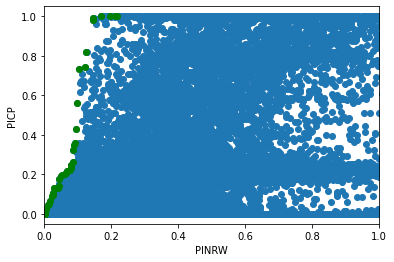

In [28]:
picp = [point[0] for point in front_positions]
pinrw = [point[1] for point in front_positions]

plt.scatter(pinrw, picp)
plt.xlim(0, 1)  # Set the limit along the pinrw axis

# Find the indices of the Pareto Front points
pareto_indices = []
for i in range(len(picp)):
    is_pareto = True
    for j in range(len(picp)):
        if picp[j] >= picp[i] and pinrw[j] <= pinrw[i] and j != i:
            is_pareto = False
            break
    if is_pareto:
        pareto_indices.append(i)


#for i in range(len(picp)):
 #   print((1-front_positions[i][1]) * (tf.exp(etta * (tf.subtract(front_positions[i][0], mu))))/max_value)

# Highlight the Pareto Front points in green
pareto_picp = [picp[i] for i in pareto_indices]
pareto_pinrw = [pinrw[i] for i in pareto_indices]
plt.scatter(pareto_pinrw, pareto_picp, color="green")

#plt.scatter(front_positions[7][0], 1-front_positions[7][1], color="red")
plt.ylabel('PICP')
plt.xlabel('PINRW')
plt.show()

<H1> Predictions section:

In [55]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

32/32 [==============================] - 0s 752us/step


In [56]:
y_test = scaler.inverse_transform(y_test)

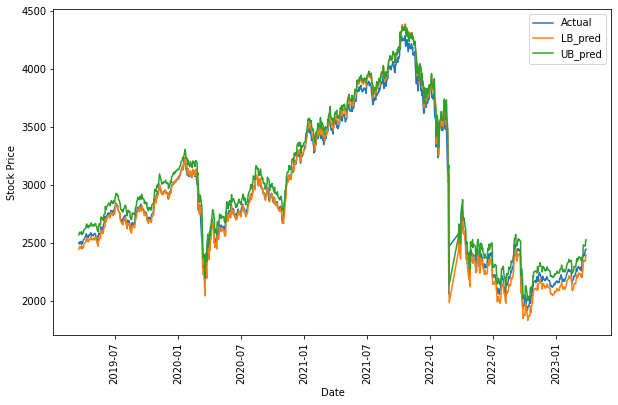

In [67]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(test['<DATE>'][1:], y_test, label='Actual')

ax.plot(test['<DATE>'][1:], y_pred[:,0], label='LB_pred')
ax.plot(test['<DATE>'][1:], y_pred[:,1], label='UB_pred')


ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()

2023-09-10 19:49:26,571 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-09-10 19:49:26,573 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-09-10 19:49:26,574 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-09-10 19:49:26,576 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-09-10 19:49:26,

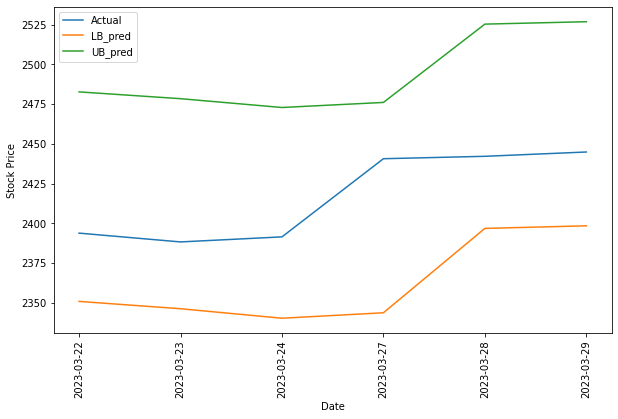

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))

last_dates = ('2023-03-22','2023-03-23','2023-03-24','2023-03-27','2023-03-28','2023-03-29')

ax.plot(last_dates, y_test[-6:], label='Actual')

ax.plot(last_dates, y_pred[-6:,0], label='LB_pred')
ax.plot(last_dates, y_pred[-6:,1], label='UB_pred')

ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()